# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install imutils
!pip install lungmask
!pip install efficientnet_pytorch
!pip install pydicom
!pip install --upgrade h5py
!pip install torchxrayvision
!pip install bokeh
!pip install datashader
!pip install holoviews
!pip install colorcet
!pip install umap-learn
!pip install efficientnet
import efficientnet.tfkeras as efn

from __future__ import print_function
import random
import os
import numpy as np
import cv2
import pydicom as pyd
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import skimage
import torchvision

import tensorflow as tf
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.models import load_model
from keras.utils import to_categorical

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.applications import ResNet50, ResNet152V2, DenseNet121
from keras.layers import (
    Dense,
    Dropout,
    Activation,
    Input,
    Flatten,
    Conv2D,
    MaxPooling2D,
    GlobalMaxPooling2D,
    BatchNormalization,
    GlobalAveragePooling2D,
)
from keras.optimizers import Adam
from keras.datasets import cifar10
from keras.preprocessing import image
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)
from keras.models import load_model

from imutils import paths
from PIL import Image
from skimage import (
    io,
    color,
    exposure,
    img_as_float,
    transform,
    measure,
)
from lungmask import mask as lungmask
from collections import OrderedDict
from torchvision.models import resnet50
from efficientnet_pytorch import EfficientNet
from torchvision import transforms
from pathlib import Path

# import xrv
import torchxrayvision as xrv
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import load_model
from keras import regularizers
from keras.layers import Dropout, GlobalAveragePooling2D, Flatten, Dense
import tensorflow as tf
from tensorflow.keras.layers import Layer
import numpy as np

# xrv.datasets.XRayResizer.engine = "cv2"

!apt-get install p7zip-full
# !7z x covid_jpeg_files.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=d47c5f558bde527c4d790a609802fdfc0a89fbb367f9b61b3b9d7b1c1810545a
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 39.7 MB/s eta 0:00:00
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━

In [ ]:
import shutil
shutil.copy("/content/drive/MyDrive/ucsd.zip", "/content/ucsd.zip")
shutil.copy("/content/drive/MyDrive/ori.zip", "/content/ori.zip")
shutil.copy("/content/drive/MyDrive/DenseNet_224_up_uncrop.h5", "/content/DenseNet_224_up_uncrop.h5")
!7z x ucsd.zip
!7z x ori.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,8 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 22471493 bytes (22 MiB)

Extracting archive: ucsd.zip
 66% 4096 Open              --
Path = ucsd.zip
Type = zip
Physical Size = 22471493

  0%     24% 1556 - ucsd/Train/Positive/VIRUS-232309-0003.jpeg                                                       38% 2512 - ucsd/Train/Positive/VIRUS-2727335-0003.jpeg                                                        47% 3112 - ucsd/Train/Positive/VIRUS-8995871-0003.jpeg

In [ ]:
mv "ucsd copy" "ucsd"

mv: cannot stat 'ucsd copy': No such file or directory


In [ ]:
mv "ori copy" "ori"

mv: cannot stat 'ori copy': No such file or directory


# Load Data

In [ ]:
class JPEGToNumpy():
    def __call__(self, sample):
        #print("Check Point 1")
        imagenet_mean = np.array([0.485, 0.456, 0.406])
        imagenet_std = np.array([0.229, 0.224, 0.225])
        img = image.load_img(sample['jpeg_path'], target_size=(224, 224),
                             color_mode='rgb', interpolation='lanczos')
        img_array = np.asarray(img, dtype='uint8')
        img_array =  img_array / 255
        centered = np.subtract(img_array, imagenet_mean)
        standardized = np.divide(centered, imagenet_std)
        sample['image'] = img_array
        return sample

class AiSeverity:
    def __init__(self, device=None):
        self.transforms = transforms.Compose([
            JPEGToNumpy(),
            # CreateLungMask(device),
            # ApplyLungMask(constant_values=-1024)
        ])

    def __call__(self, jpeg_path):
        sample = {'jpeg_path': jpeg_path}
        sample = self.transforms(sample)
        return sample['image']

# Folder paths
normal_folder = 'ucsd/Train/Negative/'
pneumonia_folder = 'ucsd/Train/Positive/'
# Initialize an empty dictionary to store file names and labels
file_labels = {}
file_samples = {}

# Set the random seed for reproducibility
np.random.seed(100)

# Assign labels to PNEUMONIA files
pneumonia_files = os.listdir(pneumonia_folder)
for file_name in pneumonia_files:
    file_path = os.path.join(pneumonia_folder, file_name)
    file_labels[file_path] = 1

# Assign labels to NORMAL files
normal_files = os.listdir(normal_folder)
for file_name in normal_files:
    file_path = os.path.join(normal_folder, file_name)
    file_labels[file_path] = 0

# Call AiSeverity method
ai_severity = AiSeverity(device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
index = 0
items_list = list(file_labels.items())

# Shuffle the list of tuples using random.shuffle()
np.random.shuffle(items_list)

# Create a new dictionary from the shuffled list of tuples
file_labels = dict(items_list)

for file_path, label in file_labels.items():
    sample = ai_severity(file_path)
    print(f'{file_path}: label is {label}')
    file_samples[file_path] = sample
    index = index + 1
    print(f"Index: {index}")

train_samples = file_samples
train_labels = file_labels

# Folder paths
normal_folder = 'ucsd/Validation/Negative/'
pneumonia_folder = 'ucsd/Validation/Positive/'
# Initialize an empty dictionary to store file names and labels
file_labels = {}
file_samples = {}

# Set the random seed for reproducibility
np.random.seed(100)

# Assign labels to PNEUMONIA files
pneumonia_files = os.listdir(pneumonia_folder)
for file_name in pneumonia_files:
    file_path = os.path.join(pneumonia_folder, file_name)
    file_labels[file_path] = 1

# Assign labels to NORMAL files
normal_files = os.listdir(normal_folder)
for file_name in normal_files:
    file_path = os.path.join(normal_folder, file_name)
    file_labels[file_path] = 0

# Call AiSeverity method
ai_severity = AiSeverity(device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
index = 0
items_list = list(file_labels.items())

# Shuffle the list of tuples using random.shuffle()
np.random.shuffle(items_list)

# Create a new dictionary from the shuffled list of tuples
file_labels = dict(items_list)

for file_path, label in file_labels.items():
    sample = ai_severity(file_path)
    print(f'{file_path}: label is {label}')
    file_samples[file_path] = sample
    index = index + 1
    print(f"Index: {index}")

validation_samples = file_samples
validation_labels = file_labels

# Folder paths
normal_folder = 'ucsd/Test/Negative/'
pneumonia_folder = 'ucsd/Test/Positive/'

# Initialize an empty dictionary to store file names and labels
file_labels = {}
file_samples = {}

# Assign labels to PNEUMONIA files
pneumonia_files = os.listdir(pneumonia_folder)
for file_name in pneumonia_files:
    file_path = os.path.join(pneumonia_folder, file_name)
    file_labels[file_path] = 1

# Assign labels to NORMAL files
normal_files = os.listdir(normal_folder)
for file_name in normal_files:
    file_path = os.path.join(normal_folder, file_name)
    file_labels[file_path] = 0

# Call AiSeverity method
ai_severity = AiSeverity(device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
index = 0
items_list = list(file_labels.items())

# Shuffle the list of tuples using random.shuffle()
np.random.shuffle(items_list)

# Create a new dictionary from the shuffled list of tuples
file_labels = dict(items_list)

for file_path, label in file_labels.items():
    sample = ai_severity(file_path)
    print(f'{file_path}: label is {label}')
    file_samples[file_path] = sample
    index = index + 1
    print(f"Index: {index}")

test_samples = file_samples
test_labels = file_labels

BATCH_SIZE_TRAINING = 64
BATCH_SIZE_VALIDATION = 64
BATCH_SIZE_TESTING = 1

train_datagen = ImageDataGenerator(
fill_mode="nearest",
    validation_split=0.20,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,

)

test_datagen = ImageDataGenerator(
fill_mode="nearest",
    validation_split=0.20,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
)

train_image_list = [(train_samples[key], train_labels[key]) for key in train_samples.keys()]
validation_image_list = [(validation_samples[key], validation_labels[key]) for key in validation_samples.keys()]
test_image_list = [(test_samples[key], test_labels[key]) for key in test_samples.keys()]

# Split the image_list into training and validation sets
train_generator_test = train_datagen.flow(
    x=np.array([image for image, label in train_image_list]),
    y=[label for image, label in train_image_list],
    batch_size=BATCH_SIZE_TRAINING,
    shuffle=True,
    seed=60
)

valid_generator_test = train_datagen.flow(
    x=np.array([image for image, label in validation_image_list]),
    y=[label for image, label in validation_image_list],
    batch_size=BATCH_SIZE_VALIDATION,
    shuffle=True,
    seed=60
)

test_generator_test = test_datagen.flow(
    x=np.array([image for image, label in test_image_list]),
    y=[label for image, label in test_image_list],
    batch_size=BATCH_SIZE_TESTING,
    shuffle=False,
    seed=60
)


Streaming output truncated to the last 5000 lines.
ucsd/Train/Positive/VIRUS-5366209-0005.jpeg: label is 1
Index: 577
ucsd/Train/Negative/NORMAL-4340661-0001.jpeg: label is 0
Index: 578
ucsd/Train/Positive/VIRUS-5564093-0003.jpeg: label is 1
Index: 579
ucsd/Train/Positive/VIRUS-3408906-0007.jpeg: label is 1
Index: 580
ucsd/Train/Positive/VIRUS-1884647-0006.jpeg: label is 1
Index: 581
ucsd/Train/Negative/NORMAL-745902-0001.jpeg: label is 0
Index: 582
ucsd/Train/Negative/NORMAL-6474092-0001.jpeg: label is 0
Index: 583
ucsd/Train/Positive/VIRUS-8608254-0002.jpeg: label is 1
Index: 584
ucsd/Train/Positive/VIRUS-666371-0002.jpeg: label is 1
Index: 585
ucsd/Train/Positive/VIRUS-5008146-0001.jpeg: label is 1
Index: 586
ucsd/Train/Positive/VIRUS-6483321-0001.jpeg: label is 1
Index: 587
ucsd/Train/Positive/VIRUS-6828836-0001.jpeg: label is 1
Index: 588
ucsd/Train/Positive/VIRUS-3826195-0001.jpeg: label is 1
Index: 589
ucsd/Train/Positive/VIRUS-7299583-0001.jpeg: label is 1
Index: 590
ucsd/Train

In [ ]:
class JPEGToNumpy():
    def __call__(self, sample):
        #print("Check Point 1")
        imagenet_mean = np.array([0.485, 0.456, 0.406])
        imagenet_std = np.array([0.229, 0.224, 0.225])
        img = image.load_img(sample['jpeg_path'], target_size=(224, 224),
                             color_mode='rgb', interpolation='lanczos')
        img_array = np.asarray(img, dtype='uint8')
        img_array =  img_array / 255
        centered = np.subtract(img_array, imagenet_mean)
        standardized = np.divide(centered, imagenet_std)
        sample['image'] = img_array
        return sample

class AiSeverity:
    def __init__(self, device=None):
        self.transforms = transforms.Compose([
            JPEGToNumpy(),
            # CreateLungMask(device),
            # ApplyLungMask(constant_values=-1024)
        ])

    def __call__(self, jpeg_path):
        sample = {'jpeg_path': jpeg_path}
        sample = self.transforms(sample)
        return sample['image']

# Folder paths
normal_folder = 'ori/Train/Negative/'
pneumonia_folder = 'ori/Train/Positive/'
# Initialize an empty dictionary to store file names and labels
file_labels = {}
file_samples = {}

# Set the random seed for reproducibility
np.random.seed(100)

# Assign labels to PNEUMONIA files
pneumonia_files = os.listdir(pneumonia_folder)
for file_name in pneumonia_files:
    file_path = os.path.join(pneumonia_folder, file_name)
    file_labels[file_path] = 1

# Assign labels to NORMAL files
normal_files = os.listdir(normal_folder)
for file_name in normal_files:
    file_path = os.path.join(normal_folder, file_name)
    file_labels[file_path] = 0

# Call AiSeverity method
ai_severity = AiSeverity(device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
index = 0
items_list = list(file_labels.items())

# Shuffle the list of tuples using random.shuffle()
np.random.shuffle(items_list)

# Create a new dictionary from the shuffled list of tuples
file_labels = dict(items_list)

for file_path, label in file_labels.items():
    sample = ai_severity(file_path)
    print(f'{file_path}: label is {label}')
    file_samples[file_path] = sample
    index = index + 1
    print(f"Index: {index}")

train_samples = file_samples
train_labels = file_labels

# Folder paths
normal_folder = 'ori/Validation/Negative/'
pneumonia_folder = 'ori/Validation/Positive/'
# Initialize an empty dictionary to store file names and labels
file_labels = {}
file_samples = {}

# Set the random seed for reproducibility
np.random.seed(100)

# Assign labels to PNEUMONIA files
pneumonia_files = os.listdir(pneumonia_folder)
for file_name in pneumonia_files:
    file_path = os.path.join(pneumonia_folder, file_name)
    file_labels[file_path] = 1

# Assign labels to NORMAL files
normal_files = os.listdir(normal_folder)
for file_name in normal_files:
    file_path = os.path.join(normal_folder, file_name)
    file_labels[file_path] = 0

# Call AiSeverity method
ai_severity = AiSeverity(device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
index = 0
items_list = list(file_labels.items())

# Shuffle the list of tuples using random.shuffle()
np.random.shuffle(items_list)

# Create a new dictionary from the shuffled list of tuples
file_labels = dict(items_list)

for file_path, label in file_labels.items():
    sample = ai_severity(file_path)
    print(f'{file_path}: label is {label}')
    file_samples[file_path] = sample
    index = index + 1
    print(f"Index: {index}")

validation_samples = file_samples
validation_labels = file_labels

# Folder paths
normal_folder = 'ori/Test/Negative/'
pneumonia_folder = 'ori/Test/Positive/'

# Initialize an empty dictionary to store file names and labels
file_labels = {}
file_samples = {}

# Assign labels to PNEUMONIA files
pneumonia_files = os.listdir(pneumonia_folder)
for file_name in pneumonia_files:
    file_path = os.path.join(pneumonia_folder, file_name)
    file_labels[file_path] = 1

# Assign labels to NORMAL files
normal_files = os.listdir(normal_folder)
for file_name in normal_files:
    file_path = os.path.join(normal_folder, file_name)
    file_labels[file_path] = 0

# Call AiSeverity method
ai_severity = AiSeverity(device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
index = 0
items_list = list(file_labels.items())

# Shuffle the list of tuples using random.shuffle()
np.random.shuffle(items_list)

# Create a new dictionary from the shuffled list of tuples
file_labels = dict(items_list)

for file_path, label in file_labels.items():
    sample = ai_severity(file_path)
    print(f'{file_path}: label is {label}')
    file_samples[file_path] = sample
    index = index + 1
    print(f"Index: {index}")

test_samples = file_samples
test_labels = file_labels

BATCH_SIZE_TRAINING = 64
BATCH_SIZE_VALIDATION = 64
BATCH_SIZE_TESTING = 1

train_datagen = ImageDataGenerator(
fill_mode="nearest",
    validation_split=0.20,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,

)

test_datagen = ImageDataGenerator(
fill_mode="nearest",
    validation_split=0.20,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
)

train_image_list = [(train_samples[key], train_labels[key]) for key in train_samples.keys()]
validation_image_list = [(validation_samples[key], validation_labels[key]) for key in validation_samples.keys()]
test_image_list = [(test_samples[key], test_labels[key]) for key in test_samples.keys()]

# Split the image_list into training and validation sets
train_generator = train_datagen.flow(
    x=np.array([image for image, label in train_image_list]),
    y=[label for image, label in train_image_list],
    batch_size=BATCH_SIZE_TRAINING,
    shuffle=True,
    seed=60
)

valid_generator = train_datagen.flow(
    x=np.array([image for image, label in validation_image_list]),
    y=[label for image, label in validation_image_list],
    batch_size=BATCH_SIZE_VALIDATION,
    shuffle=True,
    seed=60
)

test_generator = test_datagen.flow(
    x=np.array([image for image, label in test_image_list]),
    y=[label for image, label in test_image_list],
    batch_size=BATCH_SIZE_TESTING,
    shuffle=False,
    seed=60
)

ori/Train/Negative/HST2R9HQJSNO.png: label is 0
Index: 1
ori/Train/Negative/DJ08IYUNKNQ1.png: label is 0
Index: 2
ori/Train/Negative/76DDOHV8GE26.png: label is 0
Index: 3
ori/Train/Negative/CQUJXY4343FQ.png: label is 0
Index: 4
ori/Train/Negative/5TLVS7UVSYI7.png: label is 0
Index: 5
ori/Train/Positive/13S340CGD21O.png: label is 1
Index: 6
ori/Train/Positive/4UDB6PBS4AJ3.png: label is 1
Index: 7
ori/Train/Positive/BABXWTMLZL1S.png: label is 1
Index: 8
ori/Train/Negative/2L22YFN4KEH4.png: label is 0
Index: 9
ori/Train/Negative/8CLR7UC42F1A.png: label is 0
Index: 10
ori/Train/Negative/IAQ4BLGQM5AB.png: label is 0
Index: 11
ori/Train/Positive/6Y7128LA1MH7.png: label is 1
Index: 12
ori/Train/Positive/3OW75OZPLYGH.png: label is 1
Index: 13
ori/Train/Negative/B1X1MRK79EY9.png: label is 0
Index: 14
ori/Train/Positive/6OPEU97C8GJZ.png: label is 1
Index: 15
ori/Train/Positive/6XTY4LH3IAD3.png: label is 1
Index: 16
ori/Train/Positive/BX7QUJSUCCZ8.png: label is 1
Index: 17
ori/Train/Negative/IK50

# Visualize

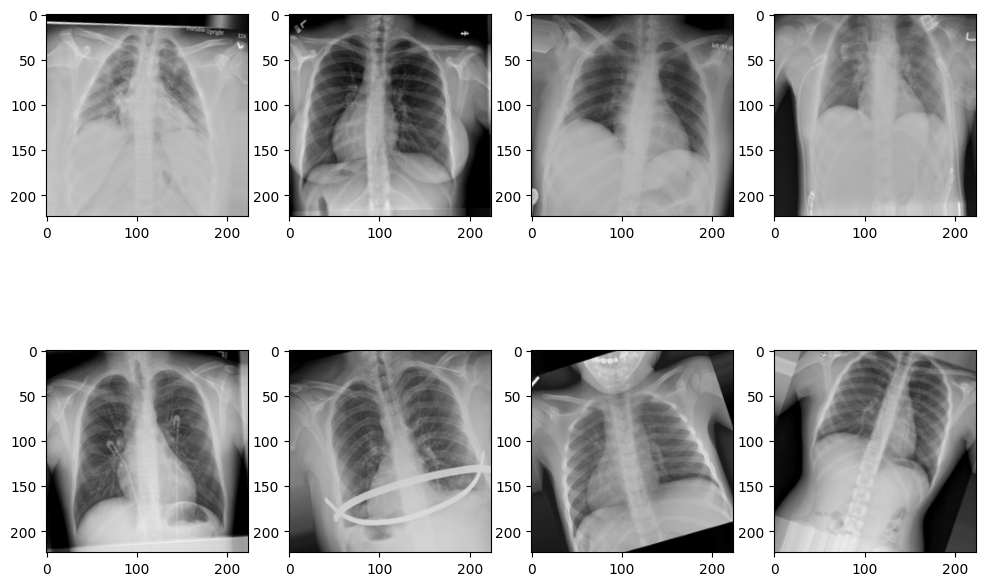

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 4, 1)
plt.imshow(train_generator[0][0][0,:,:,:])
plt.subplot(2, 4, 2)
plt.imshow(valid_generator[0][0][0,:,:,:])
plt.subplot(2, 4, 3)
plt.imshow(test_generator[0][0][0,:,:,:])
plt.subplot(2, 4, 4)
plt.imshow(train_generator[0][0][30,:,:,:])
plt.subplot(2, 4, 5)
plt.imshow(valid_generator[0][0][30,:,:,:])
plt.subplot(2, 4, 6)
plt.imshow(test_generator[5][0][0,:,:,:])
plt.subplot(2, 4, 7)
plt.imshow(train_generator[6][0][40,:,:,:])
plt.subplot(2, 4, 8)
plt.imshow(test_generator[6][0][0,:,:,:])
plt.show()

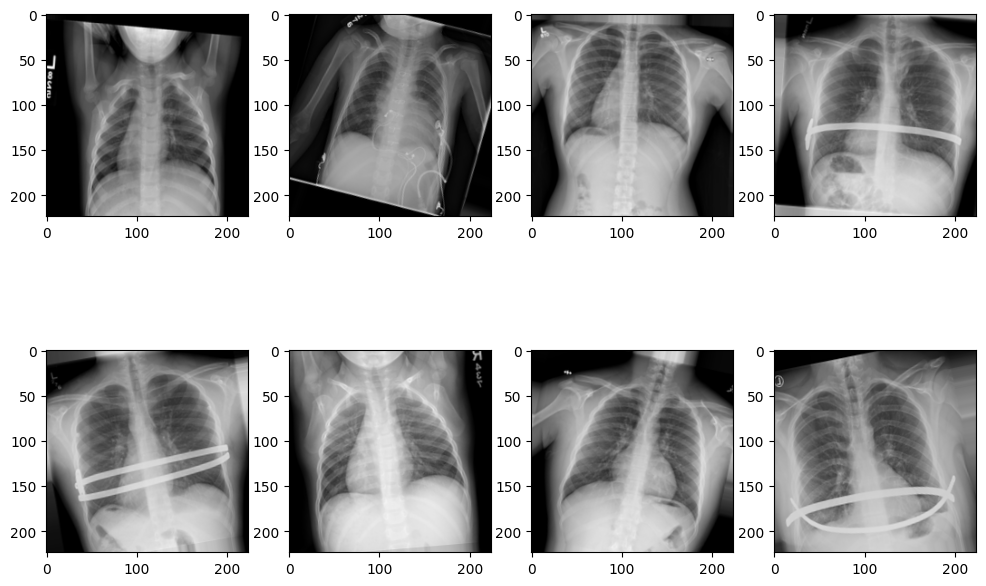

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 4, 1)
plt.imshow(train_generator[8][0][0,:,:,:])
plt.subplot(2, 4, 2)
plt.imshow(valid_generator[2][0][0,:,:,:])
plt.subplot(2, 4, 3)
plt.imshow(test_generator[6][0][0,:,:,:])
plt.subplot(2, 4, 4)
plt.imshow(train_generator[4][0][30,:,:,:])
plt.subplot(2, 4, 5)
plt.imshow(valid_generator[1][0][1,:,:,:])
plt.subplot(2, 4, 6)
plt.imshow(test_generator[3][0][0,:,:,:])
plt.subplot(2, 4, 7)
plt.imshow(train_generator[4][0][40,:,:,:])
plt.subplot(2, 4, 8)
plt.imshow(test_generator[5][0][0,:,:,:])
plt.show()

# Basic Transfer Learning 0

In [ ]:
img_size = 224
dropout = 0
weights = "DenseNet_224_up_uncrop.h5"

In [ ]:
base_model = DenseNet121(weights=None, include_top=False,
                                 input_shape = (img_size,img_size,3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0)(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.load_weights(weights)
num_layers_to_freeze = 300  # You can adjust this fraction as needed
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dropout(dropout)(x)
x = layers.Dense(128, activation='relu',)(x)
x = layers.Dropout(dropout)(x)
predictions= layers.Dense(1, activation='sigmoid',name='last')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
import tensorflow.keras.backend as K
print("Compiling the model...")
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[0] ** (1 - y_true)) * (weights[1] ** y_true) * K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
opt = Adam(lr=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy","AUC","Precision","Recall"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Compiling the model...


In [ ]:
model.summary()

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_28 (ZeroPad  (None, 230, 230, 3)          0         ['input_15[0][0]']            
 ding2D)                                                                                          
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_28[0][0]']   
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']   

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
# train the head of the network
print("training the head...")
history = model.fit(
        train_generator,
        epochs = 25,
        validation_data=valid_generator,
        callbacks=[cb_checkpointer,learning_rate_reduction,cb_early_stopper],
)
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)

training the head...
Epoch 1/25
9/9 [==============================] - 36s 2s/step - loss: 0.7359 - accuracy: 0.4753 - auc: 0.4943 - precision: 0.4559 - recall: 0.3605 - val_loss: 0.6782 - val_accuracy: 0.4924 - val_auc: 0.7901 - val_precision: 0.4923 - val_recall: 0.9846 - lr: 0.0010
Epoch 2/25
9/9 [==============================] - 11s 1s/step - loss: 0.6667 - accuracy: 0.5856 - auc: 0.6709 - precision: 0.5565 - recall: 0.7636 - val_loss: 0.6550 - val_accuracy: 0.5909 - val_auc: 0.8056 - val_precision: 1.0000 - val_recall: 0.1692 - lr: 0.0010
Epoch 3/25
9/9 [==============================] - 11s 1s/step - loss: 0.6460 - accuracy: 0.6578 - auc: 0.6930 - precision: 0.6840 - recall: 0.5620 - val_loss: 0.6310 - val_accuracy: 0.6894 - val_auc: 0.8152 - val_precision: 0.9615 - val_recall: 0.3846 - lr: 0.0010
Epoch 4/25
9/9 [==============================] - 11s 1s/step - loss: 0.6088 - accuracy: 0.7091 - auc: 0.7655 - precision: 0.7692 - recall: 0.5814 - val_loss: 0.6224 - val_accuracy: 0.

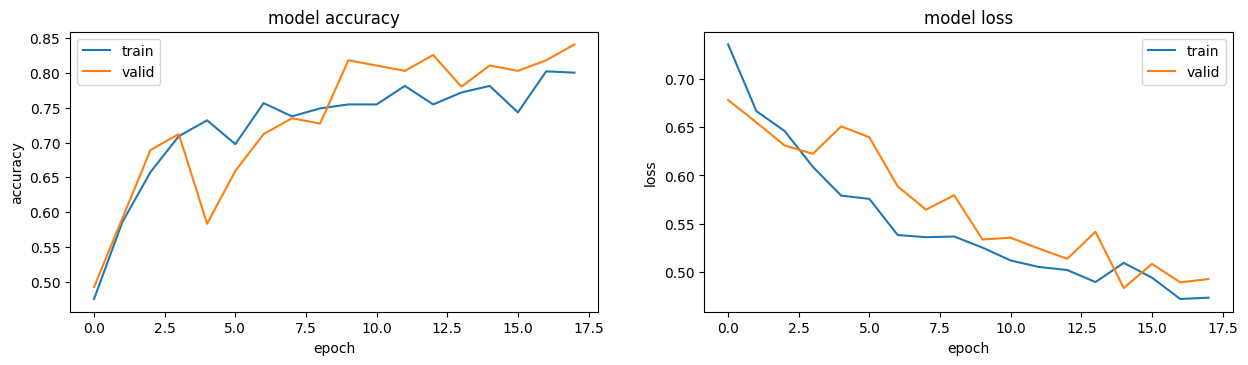

In [ ]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

In [ ]:
test_generator.reset()
prediction = model.predict(test_generator)
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(prediction))

165/165 [==============================] - 23s 121ms/step


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.7333333333333333
0.730379188712522
              precision    recall  f1-score   support

           0       0.68      0.89      0.77        84
           1       0.84      0.57      0.68        81

    accuracy                           0.73       165
   macro avg       0.76      0.73      0.72       165
weighted avg       0.76      0.73      0.73       165



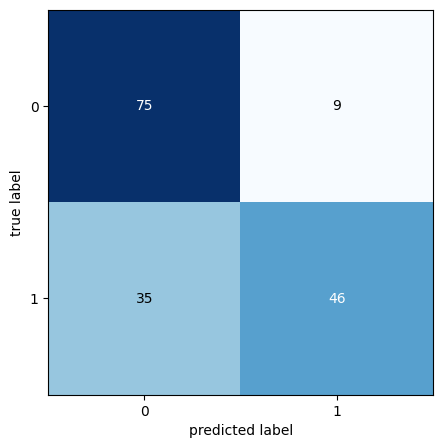

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))
plt.show()

In [ ]:
model_save_path = '/content/drive/My Drive/your_folder/"ori_one_fold_basic_transfer_0_0.h5"'
model.save(model_save_path)

616/616 [==============================] - 58s 94ms/step
(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.7775974025974026
0.7776447253199414
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       317
           1       0.77      0.78      0.77       299

    accuracy                           0.78       616
   macro avg       0.78      0.78      0.78       616
weighted avg       0.78      0.78      0.78       616



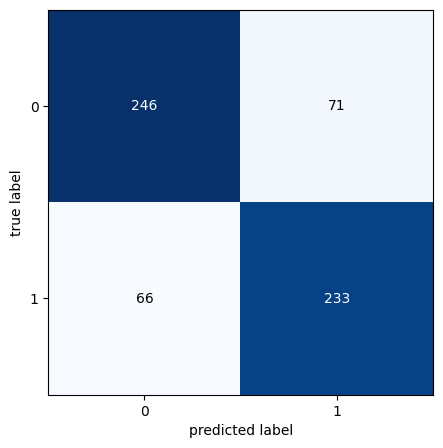

In [ ]:
train_generator_test.reset()
valid_generator_test.reset()
test_generator_test.reset()
combined_prediction = []
combined_prediction.extend(model.predict(test_generator_test))
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator_test)):
    batch_images, batch_labels = test_generator_test.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(combined_prediction))
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels.T
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))

# Basic Transfer Learning 0.3

In [ ]:
img_size = 224
dropout = 0.3
weights = "DenseNet_224_up_uncrop.h5"

In [ ]:
base_model = DenseNet121(weights=None, include_top=False,
                                 input_shape = (img_size,img_size,3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0)(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.load_weights(weights)
num_layers_to_freeze = 300  # You can adjust this fraction as needed
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dropout(dropout)(x)
x = layers.Dense(128, activation='relu',)(x)
x = layers.Dropout(dropout)(x)
predictions= layers.Dense(1, activation='sigmoid',name='last')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
import tensorflow.keras.backend as K
print("Compiling the model...")
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[0] ** (1 - y_true)) * (weights[1] ** y_true) * K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
opt = Adam(lr=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy","AUC","Precision","Recall"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Compiling the model...


In [ ]:
model.summary()

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_30 (ZeroPad  (None, 230, 230, 3)          0         ['input_16[0][0]']            
 ding2D)                                                                                          
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_30[0][0]']   
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']   

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
# train the head of the network
print("training the head...")
history = model.fit(
        train_generator,
        epochs = 25,
        validation_data=valid_generator,
        callbacks=[cb_checkpointer,learning_rate_reduction,cb_early_stopper],
)
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)

training the head...
Epoch 1/25
9/9 [==============================] - 39s 2s/step - loss: 0.7162 - accuracy: 0.5152 - auc: 0.5328 - precision: 0.5078 - recall: 0.3798 - val_loss: 0.7795 - val_accuracy: 0.4924 - val_auc: 0.7280 - val_precision: 0.4924 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/25
9/9 [==============================] - 12s 1s/step - loss: 0.7135 - accuracy: 0.5475 - auc: 0.5777 - precision: 0.5442 - recall: 0.4767 - val_loss: 0.7094 - val_accuracy: 0.5076 - val_auc: 0.7558 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/25
9/9 [==============================] - 11s 1s/step - loss: 0.6720 - accuracy: 0.5798 - auc: 0.6206 - precision: 0.5755 - recall: 0.5465 - val_loss: 0.6476 - val_accuracy: 0.7121 - val_auc: 0.8093 - val_precision: 0.6901 - val_recall: 0.7538 - lr: 0.0010
Epoch 4/25
9/9 [==============================] - 10s 1s/step - loss: 0.6373 - accuracy: 0.6540 - auc: 0.7037 - precision: 0.6583 - recall: 0.6124 - val_loss: 0.6507 - val_accu

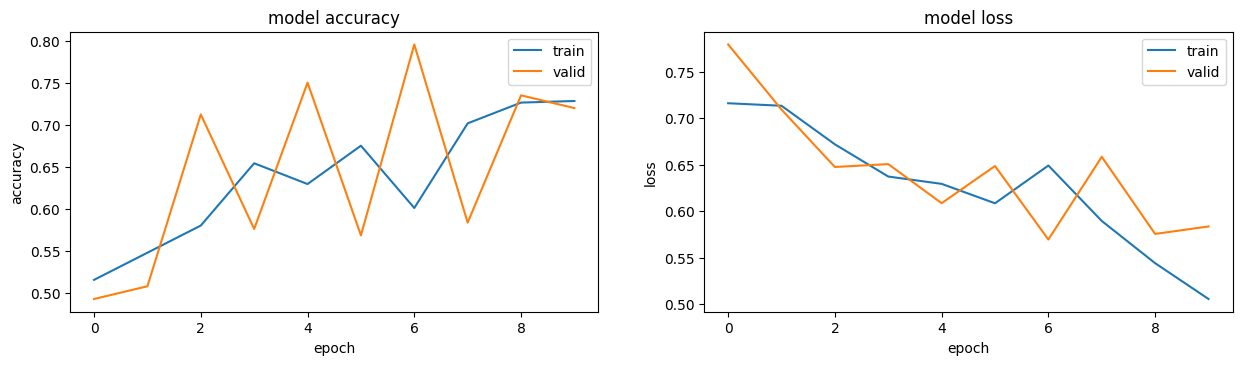

In [ ]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

In [ ]:
test_generator.reset()
prediction = model.predict(test_generator)
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(prediction))

165/165 [==============================] - 23s 126ms/step


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.6242424242424243
0.6175044091710759
              precision    recall  f1-score   support

           0       0.58      0.99      0.73        84
           1       0.95      0.25      0.39        81

    accuracy                           0.62       165
   macro avg       0.76      0.62      0.56       165
weighted avg       0.76      0.62      0.56       165



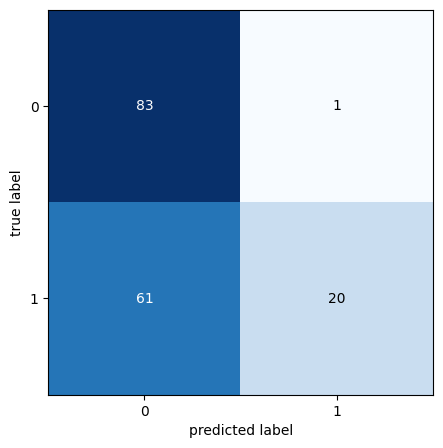

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))
plt.show()

In [ ]:
model_save_path = '/content/drive/My Drive/your_folder/"ori_one_fold_basic_transfer_0_0.h5"'
model.save(model_save_path)

616/616 [==============================] - 71s 115ms/step
(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.6396103896103896
0.6287625418060201
              precision    recall  f1-score   support

           0       0.59      1.00      0.74       317
           1       1.00      0.26      0.41       299

    accuracy                           0.64       616
   macro avg       0.79      0.63      0.58       616
weighted avg       0.79      0.64      0.58       616



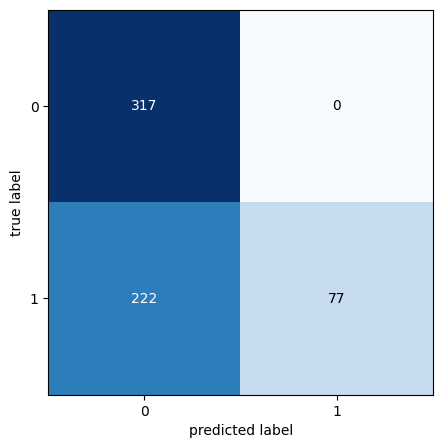

In [ ]:
train_generator_test.reset()
valid_generator_test.reset()
test_generator_test.reset()
combined_prediction = []
combined_prediction.extend(model.predict(test_generator_test))
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator_test)):
    batch_images, batch_labels = test_generator_test.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(combined_prediction))
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels.T
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))

# Basic Transfer Learning 0.6

In [ ]:
img_size = 224
dropout = 0.6
weights = "DenseNet_224_up_uncrop.h5"

In [ ]:
base_model = DenseNet121(weights=None, include_top=False,
                                 input_shape = (img_size,img_size,3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0)(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.load_weights(weights)
num_layers_to_freeze = 300  # You can adjust this fraction as needed
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dropout(dropout)(x)
x = layers.Dense(128, activation='relu',)(x)
x = layers.Dropout(dropout)(x)
predictions= layers.Dense(1, activation='sigmoid',name='last')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
import tensorflow.keras.backend as K
print("Compiling the model...")
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[0] ** (1 - y_true)) * (weights[1] ** y_true) * K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
opt = Adam(lr=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy","AUC","Precision","Recall"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Compiling the model...


In [ ]:
model.summary()

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_32 (ZeroPad  (None, 230, 230, 3)          0         ['input_17[0][0]']            
 ding2D)                                                                                          
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_32[0][0]']   
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']   

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
# train the head of the network
print("training the head...")
history = model.fit(
        train_generator,
        epochs = 25,
        validation_data=valid_generator,
        callbacks=[cb_checkpointer,learning_rate_reduction,cb_early_stopper],
)
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)

training the head...
Epoch 1/25
9/9 [==============================] - 41s 2s/step - loss: 0.8208 - accuracy: 0.4962 - auc: 0.5082 - precision: 0.4856 - recall: 0.4574 - val_loss: 0.6805 - val_accuracy: 0.5606 - val_auc: 0.7028 - val_precision: 0.5340 - val_recall: 0.8462 - lr: 0.0010
Epoch 2/25
9/9 [==============================] - 11s 1s/step - loss: 0.7963 - accuracy: 0.4791 - auc: 0.4785 - precision: 0.4690 - recall: 0.4690 - val_loss: 0.6799 - val_accuracy: 0.5076 - val_auc: 0.7463 - val_precision: 0.5000 - val_recall: 0.9692 - lr: 0.0010
Epoch 3/25
9/9 [==============================] - 11s 1s/step - loss: 0.7224 - accuracy: 0.5209 - auc: 0.5394 - precision: 0.5128 - recall: 0.4651 - val_loss: 0.6784 - val_accuracy: 0.5833 - val_auc: 0.7619 - val_precision: 0.5463 - val_recall: 0.9077 - lr: 0.0010
Epoch 4/25
9/9 [==============================] - 11s 1s/step - loss: 0.6904 - accuracy: 0.5532 - auc: 0.5931 - precision: 0.5421 - recall: 0.5736 - val_loss: 0.6747 - val_accuracy: 0.

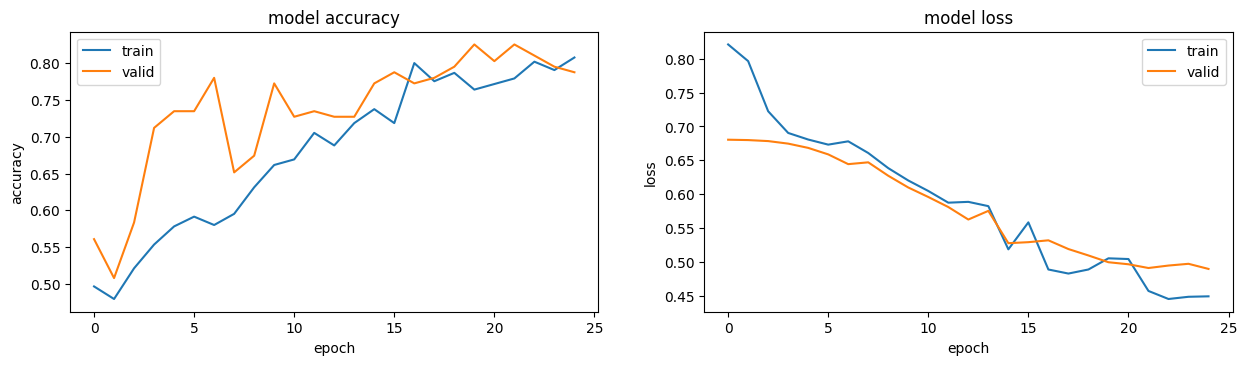

In [ ]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

In [ ]:
test_generator.reset()
prediction = model.predict(test_generator)
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(prediction))

165/165 [==============================] - 25s 137ms/step


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.703030303030303
0.6984126984126984
              precision    recall  f1-score   support

           0       0.64      0.95      0.77        84
           1       0.90      0.44      0.60        81

    accuracy                           0.70       165
   macro avg       0.77      0.70      0.68       165
weighted avg       0.77      0.70      0.68       165



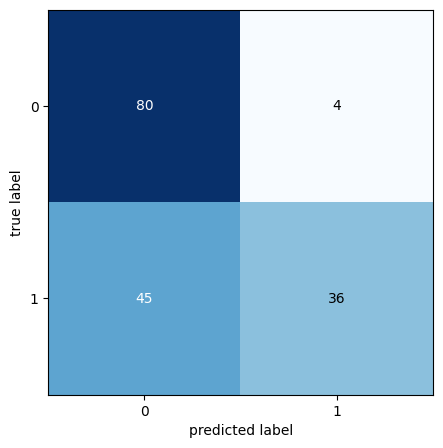

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))
plt.show()

In [ ]:
model_save_path = '/content/drive/My Drive/your_folder/"ori_one_fold_basic_transfer_0_0.h5"'
model.save(model_save_path)

616/616 [==============================] - 82s 133ms/step
(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.7386363636363636
0.7329531667071099
              precision    recall  f1-score   support

           0       0.68      0.93      0.79       317
           1       0.88      0.54      0.67       299

    accuracy                           0.74       616
   macro avg       0.78      0.73      0.73       616
weighted avg       0.77      0.74      0.73       616



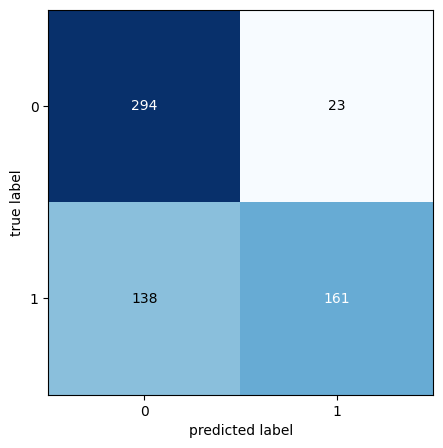

In [ ]:
train_generator_test.reset()
valid_generator_test.reset()
test_generator_test.reset()
combined_prediction = []
combined_prediction.extend(model.predict(test_generator_test))
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator_test)):
    batch_images, batch_labels = test_generator_test.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(combined_prediction))
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels.T
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))

# Basic Transfer Learning 0.9

In [ ]:
img_size = 224
dropout = 0.9
weights = "DenseNet_224_up_uncrop.h5"

In [ ]:
base_model = DenseNet121(weights=None, include_top=False,
                                 input_shape = (img_size,img_size,3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0)(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.load_weights(weights)
num_layers_to_freeze = 300  # You can adjust this fraction as needed
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dropout(dropout)(x)
x = layers.Dense(128, activation='relu',)(x)
x = layers.Dropout(dropout)(x)
predictions= layers.Dense(1, activation='sigmoid',name='last')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
import tensorflow.keras.backend as K
print("Compiling the model...")
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[0] ** (1 - y_true)) * (weights[1] ** y_true) * K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
opt = Adam(lr=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy","AUC","Precision","Recall"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Compiling the model...


In [ ]:
model.summary()

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_34 (ZeroPad  (None, 230, 230, 3)          0         ['input_18[0][0]']            
 ding2D)                                                                                          
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_34[0][0]']   
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']   

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
# train the head of the network
print("training the head...")
history = model.fit(
        train_generator,
        epochs = 25,
        validation_data=valid_generator,
        callbacks=[cb_checkpointer,learning_rate_reduction,cb_early_stopper],
)
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)

training the head...
Epoch 1/25
9/9 [==============================] - 36s 2s/step - loss: 2.2038 - accuracy: 0.4810 - auc: 0.4761 - precision: 0.4777 - recall: 0.6240 - val_loss: 0.7082 - val_accuracy: 0.5076 - val_auc: 0.4921 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/25
9/9 [==============================] - 10s 1s/step - loss: 1.5448 - accuracy: 0.5323 - auc: 0.5330 - precision: 0.5207 - recall: 0.5853 - val_loss: 0.7409 - val_accuracy: 0.5076 - val_auc: 0.4590 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/25
9/9 [==============================] - ETA: 0s - loss: 1.5055 - accuracy: 0.4905 - auc: 0.4945 - precision: 0.4795 - recall: 0.4535
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
9/9 [==============================] - 10s 1s/step - loss: 1.5055 - accuracy: 0.4905 - auc: 0.4945 - precision: 0.4795 - recall: 0.4535 - val_loss: 0.7241 - val_accuracy: 0.5076 - val_auc: 0.5238 - val_precision: 0

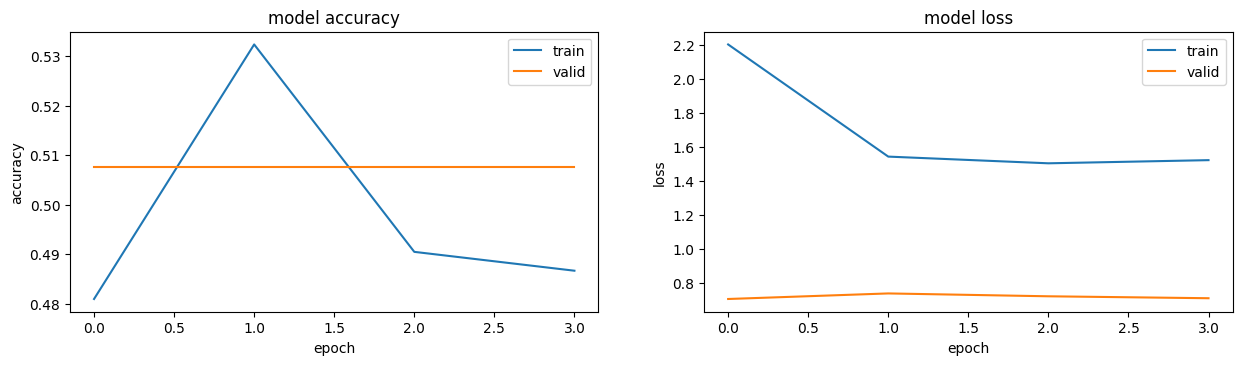

In [ ]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

In [ ]:
test_generator.reset()
prediction = model.predict(test_generator)
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(prediction))

165/165 [==============================] - 18s 97ms/step


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.509090909090909
0.5
              precision    recall  f1-score   support

           0       0.51      1.00      0.67        84
           1       0.00      0.00      0.00        81

    accuracy                           0.51       165
   macro avg       0.25      0.50      0.34       165
weighted avg       0.26      0.51      0.34       165



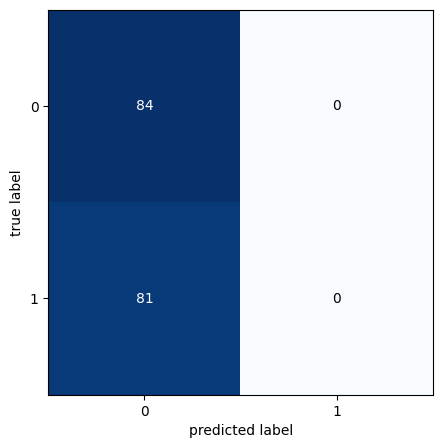

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))
plt.show()

In [ ]:
model_save_path = '/content/drive/My Drive/your_folder/"ori_one_fold_basic_transfer_0_0.h5"'
model.save(model_save_path)

616/616 [==============================] - 74s 121ms/step
(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.5146103896103896
0.5
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       317
           1       0.00      0.00      0.00       299

    accuracy                           0.51       616
   macro avg       0.26      0.50      0.34       616
weighted avg       0.26      0.51      0.35       616



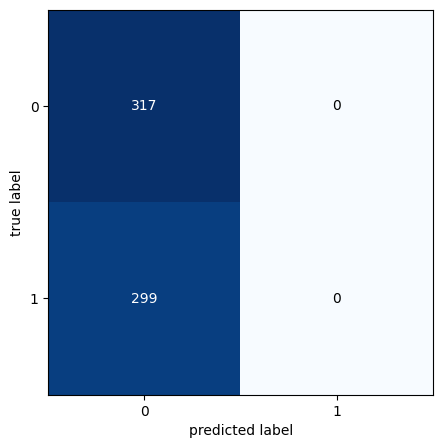

In [ ]:
train_generator_test.reset()
valid_generator_test.reset()
test_generator_test.reset()
combined_prediction = []
combined_prediction.extend(model.predict(test_generator_test))
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator_test)):
    batch_images, batch_labels = test_generator_test.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(combined_prediction))
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels.T
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))

# New Transfer Learning 0 Iterations = 0

In [ ]:
valid_generator.reset()

In [ ]:
img_size = 224
dropout_prob = 0
weights = "DenseNet_224_up_uncrop.h5"
iterations = 0

In [ ]:
class CustomDropout(Layer):
    def __init__(self, dropout_prob,weights = None):
        super(CustomDropout, self).__init__()
        self.dropout_prob = dropout_prob
        self.masks = None

    def call(self, train_inputs, training=False):
        if training:
          if self.masks is not None:
            modified_object = train_inputs * self.masks
            modified_tensor = tf.convert_to_tensor(modified_object)
            return modified_tensor
        return train_inputs

In [ ]:
base_model = DenseNet121(weights=None, include_top=False,
                                 input_shape = (img_size,img_size,3))
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout = CustomDropout(dropout_prob)
x = dropout(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))
model.load_weights(weights)
num_layers_to_freeze = 300  # You can adjust this fraction as needed
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout_one = CustomDropout(dropout_prob)
x = dropout_one(x)
before_predictions = layers.Dense(128, activation='relu')
x = before_predictions(x)
dropout_two = CustomDropout(dropout_prob)
x = dropout_two(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))

In [ ]:
import tensorflow.keras.backend as K
print("Compiling the model...")
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[0] ** (1 - y_true)) * (weights[1] ** y_true) * K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
opt = Adam(lr=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy","AUC","Precision","Recall"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Compiling the model...


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
num_batches_to_consider = len(valid_generator)
num_batches_to_consider

3

In [ ]:
def custom_random_binomial(random_values,shape, prob, object_to_modify):
    random_values = np.broadcast_to(random_values, shape)
    mask = (random_values < (1-prob)).astype(np.float32)
    modified_object = object_to_modify * mask
    modified_tensor = tf.convert_to_tensor(modified_object)
    return modified_tensor,mask

In [ ]:
def custom_valid_generator(generator, subset_indices):
    max_index = max(subset_indices, default=-1)
    for i, (x, y) in enumerate(generator):
        if i <= max_index:
            yield (x, y)
        else:
            return

In [ ]:
# train the head of the network
def calculate_metric(test_y, test_preds, metric):
  if metric == "auc":
    try:
      # auc = roc_auc_score(test_y.numpy(), np.argmax(test_preds.numpy(), axis=1))
      auc = roc_auc_score(test_y.numpy(),test_preds.numpy())
      return auc
    except:
      return 0.0
    else:
      raise ValueError("Unsupported metric: " + metric)
print("training the head...")
hist_df_list = []
epochs = 25
dropout = [dropout_one,dropout_two]
for i in range(epochs):
  print(f"Epochs {i+1}")
  best_dropout_score = float("-inf")
  weight_best = None
  if dropout_prob < 0 or dropout_prob > 1:
    raise ValueError('Dropout probability has to be between 0 and 1, but got ' + str(dropout_prob))
  for iteration in range(iterations):
    np.random.seed((i+1) * iterations)
    # dropout_layer = tf.keras.layers.Dropout(dropout_prob)
    vbatch_images_array = []
    vbatch_labels_array = []
    for v_step in range(num_batches_to_consider):
      vbatch_images, vbatch_labels = valid_generator[v_step]
      vbatch_images_array.append(vbatch_images)
      vbatch_labels_array.append(vbatch_labels)
    vbatch_images = np.concatenate(vbatch_images_array)
    vbatch_labels = np.concatenate(vbatch_labels_array)

    output = globa(base_model(vbatch_images))
    shape = output.shape
    random_values_one = np.random.random(shape)[0]
    non_mask_one,mask_numpy_one = custom_random_binomial(random_values_one,shape,dropout_prob,output)
    output = before_predictions(non_mask_one)
    shape = output.shape
    random_values_two = np.random.random(shape)[0]
    non_mask_two,mask_numpy_two = custom_random_binomial(random_values_two,shape,dropout_prob,output)
    dropout_score = calculate_metric(vbatch_labels,predictions(non_mask_two),"auc")
    if dropout_score > best_dropout_score:
      best_dropout_score = dropout_score
      weight_best_one = random_values_one
      weight_best_two = random_values_two
  if weight_best is not None:
    dropout[0].masks = weight_best_one
    dropout[1].masks = weight_best_two
  model.compile(loss='binary_crossentropy', optimizer="RMSprop", metrics=["accuracy","AUC","Precision","Recall"])
  history = model.fit(
          train_generator,
          epochs = 1,
          validation_data=valid_generator,
          callbacks=[cb_checkpointer,learning_rate_reduction,cb_early_stopper],
   )
  epoch_hist_df = pd.DataFrame(history.history)
  hist_df_list.append(epoch_hist_df)

# convert the history.history dict to a pandas DataFrame:
hist_df = pd.concat(hist_df_list, ignore_index=True)

training the head...
Epochs 1
9/9 [==============================] - 46s 2s/step - loss: 0.8106 - accuracy: 0.5228 - auc: 0.5210 - precision: 0.5125 - recall: 0.5543 - val_loss: 0.6808 - val_accuracy: 0.5227 - val_auc: 0.7467 - val_precision: 0.5079 - val_recall: 0.9846 - lr: 0.0010
Epochs 2
9/9 [==============================] - 28s 2s/step - loss: 0.6997 - accuracy: 0.5380 - auc: 0.5646 - precision: 0.5336 - recall: 0.4612 - val_loss: 0.6708 - val_accuracy: 0.5530 - val_auc: 0.7922 - val_precision: 1.0000 - val_recall: 0.0923 - lr: 0.0010
Epochs 3
9/9 [==============================] - 28s 1s/step - loss: 0.7012 - accuracy: 0.5741 - auc: 0.6135 - precision: 0.5714 - recall: 0.5271 - val_loss: 0.6584 - val_accuracy: 0.6212 - val_auc: 0.7998 - val_precision: 0.5789 - val_recall: 0.8462 - lr: 0.0010
Epochs 4
9/9 [==============================] - 29s 2s/step - loss: 0.6676 - accuracy: 0.6103 - auc: 0.6275 - precision: 0.6345 - recall: 0.4845 - val_loss: 0.6527 - val_accuracy: 0.5530 - v

9/9 [==============================] - 29s 2s/step - loss: 0.6378 - accuracy: 0.6445 - auc: 0.7004 - precision: 0.6360 - recall: 0.6434 - val_loss: 0.6289 - val_accuracy: 0.6667 - val_auc: 0.8154 - val_precision: 1.0000 - val_recall: 0.3231 - lr: 0.0010
Epochs 6
9/9 [==============================] - ETA: 0s - loss: 0.6244 - accuracy: 0.6768 - auc: 0.7094 - precision: 0.7000 - recall: 0.5969

9/9 [==============================] - 28s 2s/step - loss: 0.6244 - accuracy: 0.6768 - auc: 0.7094 - precision: 0.7000 - recall: 0.5969 - val_loss: 0.5877 - val_accuracy: 0.7197 - val_auc: 0.8185 - val_precision: 0.6892 - val_recall: 0.7846 - lr: 0.0010
Epochs 7
9/9 [==============================] - 31s 2s/step - loss: 0.5978 - accuracy: 0.6844 - auc: 0.7376 - precision: 0.6983 - recall: 0.6279 - val_loss: 0.5692 - val_accuracy: 0.7727 - val_auc: 0.8103 - val_precision: 0.7869 - val_recall: 0.7385 - lr: 0.0010
Epochs 8
9/9 [==============================] - 29s 2s/step - loss: 0.5625 - accuracy: 0.7243 - auc: 0.7770 - precision: 0.7628 - recall: 0.6357 - val_loss: 0.5508 - val_accuracy: 0.7879 - val_auc: 0.8216 - val_precision: 0.8491 - val_recall: 0.6923 - lr: 0.0010
Epochs 9
9/9 [==============================] - 29s 2s/step - loss: 0.5848 - accuracy: 0.7148 - auc: 0.7523 - precision: 0.7755 - recall: 0.5891 - val_loss: 0.5280 - val_accuracy: 0.7955 - val_auc: 0.8374 - val_precision

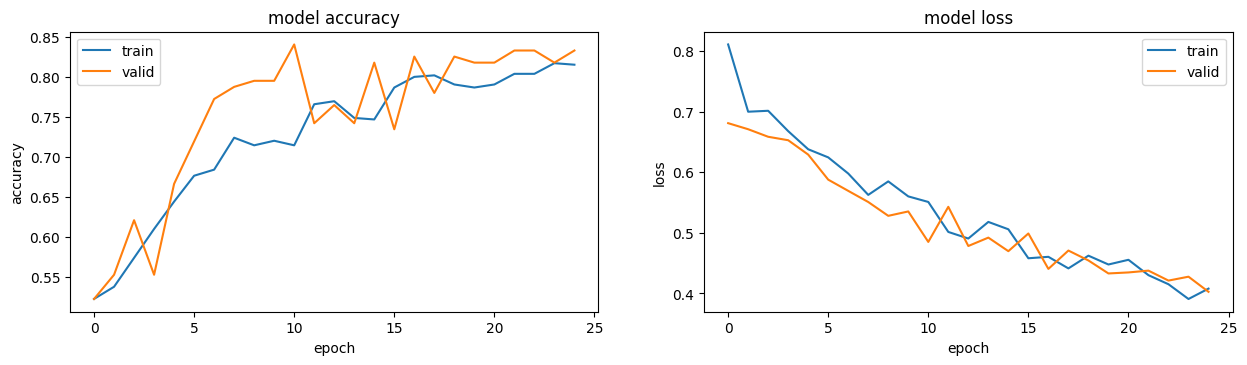

In [ ]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(hist_df['accuracy'])
plt.plot(hist_df['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

In [ ]:
test_generator.reset()
prediction = model.predict(test_generator)
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(prediction))

165/165 [==============================] - 14s 65ms/step


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.7515151515151515
0.7491181657848324
              precision    recall  f1-score   support

           0       0.70      0.88      0.78        84
           1       0.83      0.62      0.71        81

    accuracy                           0.75       165
   macro avg       0.77      0.75      0.75       165
weighted avg       0.77      0.75      0.75       165



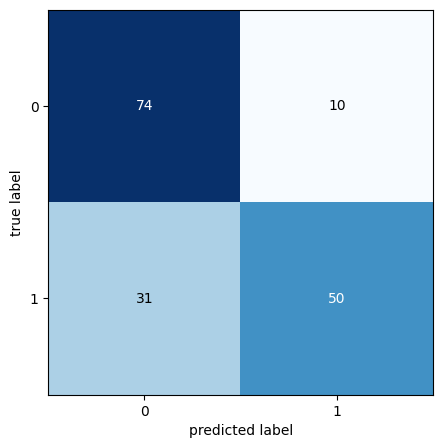

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
predicted_class_indices = np.round(predicted_class_indices)
y_test = labels
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))
plt.show()

In [ ]:
model_save_path = '/content/drive/My Drive/your_folder/"ori_one_fold_new_transfer_09_20.h5"'
model.save(model_save_path)

616/616 [==============================] - 55s 89ms/step
(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.7727272727272727
0.7731977253304917
              precision    recall  f1-score   support

           0       0.79      0.76      0.77       317
           1       0.75      0.79      0.77       299

    accuracy                           0.77       616
   macro avg       0.77      0.77      0.77       616
weighted avg       0.77      0.77      0.77       616



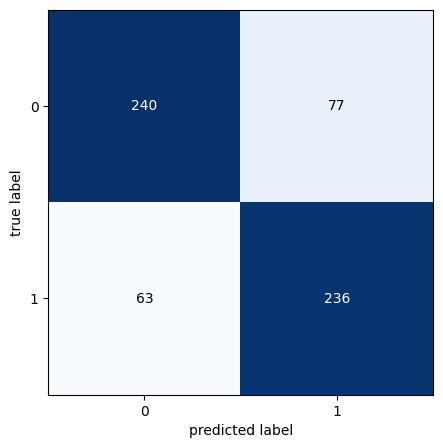

In [ ]:
train_generator_test.reset()
valid_generator_test.reset()
test_generator_test.reset()
combined_prediction = []
combined_prediction.extend(model.predict(test_generator_test))
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator_test)):
    batch_images, batch_labels = test_generator_test.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(combined_prediction))
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels.T
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))

# New Transfer Learning 0.3 Iterations = 10

In [ ]:
valid_generator.reset()

In [ ]:
img_size = 224
dropout_prob = 0.3
weights = "DenseNet_224_up_uncrop.h5"
iterations = 10

In [ ]:
class CustomDropout(Layer):
    def __init__(self, dropout_prob,weights = None):
        super(CustomDropout, self).__init__()
        self.dropout_prob = dropout_prob
        self.masks = None

    def call(self, train_inputs, training=False):
        if training:
          if self.masks is not None:
            modified_object = train_inputs * self.masks
            modified_tensor = tf.convert_to_tensor(modified_object)
            return modified_tensor
        return train_inputs

In [ ]:
base_model = DenseNet121(weights=None, include_top=False,
                                 input_shape = (img_size,img_size,3))
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout = CustomDropout(dropout_prob)
x = dropout(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))
model.load_weights(weights)
num_layers_to_freeze = 300  # You can adjust this fraction as needed
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout_one = CustomDropout(dropout_prob)
x = dropout_one(x)
before_predictions = layers.Dense(128, activation='relu')
x = before_predictions(x)
dropout_two = CustomDropout(dropout_prob)
x = dropout_two(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))

In [ ]:
import tensorflow.keras.backend as K
print("Compiling the model...")
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[0] ** (1 - y_true)) * (weights[1] ** y_true) * K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
opt = Adam(lr=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy","AUC","Precision","Recall"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Compiling the model...


In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
num_batches_to_consider = len(valid_generator)
num_batches_to_consider

3

In [ ]:
def custom_random_binomial(random_values,shape, prob, object_to_modify):
    random_values = np.broadcast_to(random_values, shape)
    mask = (random_values < (1-prob)).astype(np.float32)
    modified_object = object_to_modify * mask
    modified_tensor = tf.convert_to_tensor(modified_object)
    return modified_tensor,mask

In [ ]:
def custom_valid_generator(generator, subset_indices):
    max_index = max(subset_indices, default=-1)
    for i, (x, y) in enumerate(generator):
        if i <= max_index:
            yield (x, y)
        else:
            return

In [ ]:
# train the head of the network
def calculate_metric(test_y, test_preds, metric):
  if metric == "auc":
    try:
      # auc = roc_auc_score(test_y.numpy(), np.argmax(test_preds.numpy(), axis=1))
      auc = roc_auc_score(test_y.numpy(),test_preds.numpy())
      return auc
    except:
      return 0.0
    else:
      raise ValueError("Unsupported metric: " + metric)
print("training the head...")
hist_df_list = []
epochs = 25
dropout = [dropout_one,dropout_two]
for i in range(epochs):
  print(f"Epochs {i+1}")
  best_dropout_score = float("-inf")
  weight_best = None
  if dropout_prob < 0 or dropout_prob > 1:
    raise ValueError('Dropout probability has to be between 0 and 1, but got ' + str(dropout_prob))
  for iteration in range(iterations):
    np.random.seed((i+1) * iterations)
    # dropout_layer = tf.keras.layers.Dropout(dropout_prob)
    vbatch_images_array = []
    vbatch_labels_array = []
    for v_step in range(num_batches_to_consider):
      vbatch_images, vbatch_labels = valid_generator[v_step]
      vbatch_images_array.append(vbatch_images)
      vbatch_labels_array.append(vbatch_labels)
    vbatch_images = np.concatenate(vbatch_images_array)
    vbatch_labels = np.concatenate(vbatch_labels_array)

    output = globa(base_model(vbatch_images))
    shape = output.shape
    random_values_one = np.random.random(shape)[0]
    non_mask_one,mask_numpy_one = custom_random_binomial(random_values_one,shape,dropout_prob,output)
    output = before_predictions(non_mask_one)
    shape = output.shape
    random_values_two = np.random.random(shape)[0]
    non_mask_two,mask_numpy_two = custom_random_binomial(random_values_two,shape,dropout_prob,output)
    dropout_score = calculate_metric(vbatch_labels,predictions(non_mask_two),"auc")
    if dropout_score > best_dropout_score:
      best_dropout_score = dropout_score
      weight_best_one = random_values_one
      weight_best_two = random_values_two
  if weight_best is not None:
    dropout[0].masks = weight_best_one
    dropout[1].masks = weight_best_two
  model.compile(loss='binary_crossentropy', optimizer="RMSprop", metrics=["accuracy","AUC","Precision","Recall"])
  history = model.fit(
          train_generator,
          epochs = 1,
          validation_data=valid_generator,
          callbacks=[cb_checkpointer,learning_rate_reduction,cb_early_stopper],
   )
  epoch_hist_df = pd.DataFrame(history.history)
  hist_df_list.append(epoch_hist_df)

# convert the history.history dict to a pandas DataFrame:
hist_df = pd.concat(hist_df_list, ignore_index=True)

training the head...
Epochs 1
9/9 [==============================] - 32s 2s/step - loss: 0.8853 - accuracy: 0.5038 - auc: 0.5258 - precision: 0.4925 - recall: 0.3837 - val_loss: 0.7376 - val_accuracy: 0.5076 - val_auc: 0.7470 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epochs 2
9/9 [==============================] - 29s 1s/step - loss: 0.7258 - accuracy: 0.5456 - auc: 0.5678 - precision: 0.5419 - recall: 0.4767 - val_loss: 0.6813 - val_accuracy: 0.5076 - val_auc: 0.7652 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epochs 3
9/9 [==============================] - 29s 2s/step - loss: 0.7064 - accuracy: 0.5361 - auc: 0.5873 - precision: 0.5412 - recall: 0.3566 - val_loss: 0.6889 - val_accuracy: 0.4924 - val_auc: 0.7752 - val_precision: 0.4924 - val_recall: 1.0000 - lr: 0.0010
Epochs 4
9/9 [==============================] - 29s 1s/step - loss: 0.6618 - accuracy: 0.5856 - auc: 0.6532 - precision: 0.5633 - recall: 0.6899 - val_loss: 0.6512 - val_accu

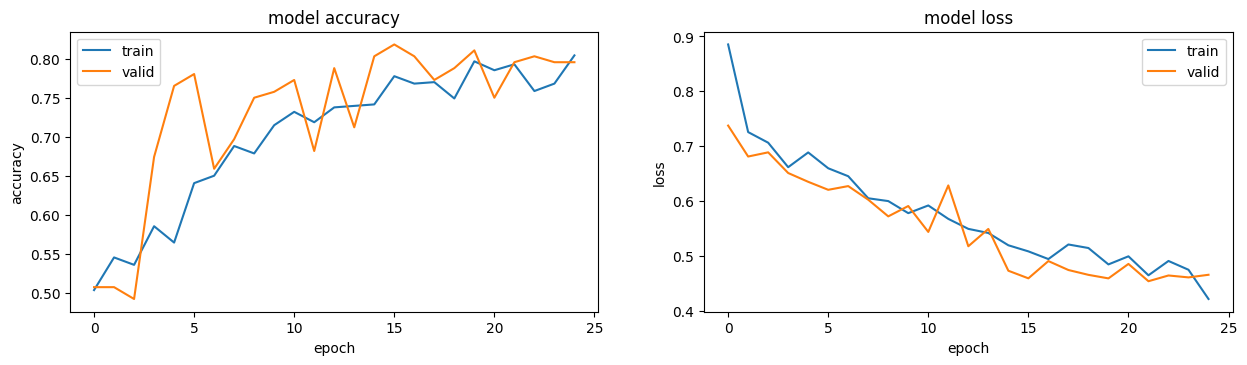

In [ ]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(hist_df['accuracy'])
plt.plot(hist_df['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

In [ ]:
test_generator.reset()
prediction = model.predict(test_generator)
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(prediction))

165/165 [==============================] - 7s 31ms/step


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.6909090909090909
0.6911375661375662
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        84
           1       0.68      0.70      0.69        81

    accuracy                           0.69       165
   macro avg       0.69      0.69      0.69       165
weighted avg       0.69      0.69      0.69       165



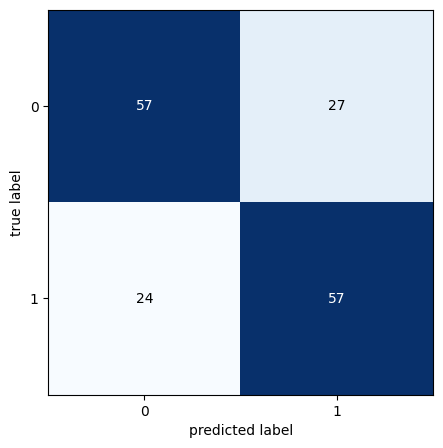

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
predicted_class_indices = np.round(predicted_class_indices)
y_test = labels
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))
plt.show()

In [ ]:
model_save_path = '/content/drive/My Drive/your_folder/"ori_one_fold_new_transfer_09_20.h5"'
model.save(model_save_path)

616/616 [==============================] - 76s 124ms/step
(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.5665584415584416
0.5764905099015646
              precision    recall  f1-score   support

           0       0.75      0.24      0.36       317
           1       0.53      0.92      0.67       299

    accuracy                           0.57       616
   macro avg       0.64      0.58      0.52       616
weighted avg       0.64      0.57      0.51       616



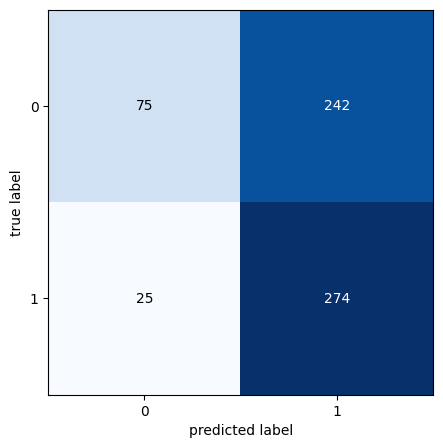

In [ ]:
train_generator_test.reset()
valid_generator_test.reset()
test_generator_test.reset()
combined_prediction = []
combined_prediction.extend(model.predict(test_generator_test))
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator_test)):
    batch_images, batch_labels = test_generator_test.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(combined_prediction))
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels.T
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))

# New Transfer Learning 0.6 Iterations = 10

In [ ]:
valid_generator.reset()

In [ ]:
img_size = 224
dropout_prob = 0.6
weights = "DenseNet_224_up_uncrop.h5"
iterations = 10

In [ ]:
class CustomDropout(Layer):
    def __init__(self, dropout_prob,weights = None):
        super(CustomDropout, self).__init__()
        self.dropout_prob = dropout_prob
        self.masks = None

    def call(self, train_inputs, training=False):
        if training:
          if self.masks is not None:
            modified_object = train_inputs * self.masks
            modified_tensor = tf.convert_to_tensor(modified_object)
            return modified_tensor
        return train_inputs

In [ ]:
base_model = DenseNet121(weights=None, include_top=False,
                                 input_shape = (img_size,img_size,3))
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout = CustomDropout(dropout_prob)
x = dropout(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))
model.load_weights(weights)
num_layers_to_freeze = 300  # You can adjust this fraction as needed
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout_one = CustomDropout(dropout_prob)
x = dropout_one(x)
before_predictions = layers.Dense(128, activation='relu')
x = before_predictions(x)
dropout_two = CustomDropout(dropout_prob)
x = dropout_two(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))

In [ ]:
import tensorflow.keras.backend as K
print("Compiling the model...")
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[0] ** (1 - y_true)) * (weights[1] ** y_true) * K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
opt = Adam(lr=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy","AUC","Precision","Recall"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Compiling the model...


In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 230, 230, 3)          0         ['input_3[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_4[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
num_batches_to_consider = len(valid_generator)
num_batches_to_consider

3

In [ ]:
def custom_random_binomial(random_values,shape, prob, object_to_modify):
    random_values = np.broadcast_to(random_values, shape)
    mask = (random_values < (1-prob)).astype(np.float32)
    modified_object = object_to_modify * mask
    modified_tensor = tf.convert_to_tensor(modified_object)
    return modified_tensor,mask

In [ ]:
def custom_valid_generator(generator, subset_indices):
    max_index = max(subset_indices, default=-1)
    for i, (x, y) in enumerate(generator):
        if i <= max_index:
            yield (x, y)
        else:
            return

In [ ]:
# train the head of the network
def calculate_metric(test_y, test_preds, metric):
  if metric == "auc":
    try:
      # auc = roc_auc_score(test_y.numpy(), np.argmax(test_preds.numpy(), axis=1))
      auc = roc_auc_score(test_y.numpy(),test_preds.numpy())
      return auc
    except:
      return 0.0
    else:
      raise ValueError("Unsupported metric: " + metric)
print("training the head...")
hist_df_list = []
epochs = 25
dropout = [dropout_one,dropout_two]
for i in range(epochs):
  print(f"Epochs {i+1}")
  best_dropout_score = float("-inf")
  weight_best = None
  if dropout_prob < 0 or dropout_prob > 1:
    raise ValueError('Dropout probability has to be between 0 and 1, but got ' + str(dropout_prob))
  for iteration in range(iterations):
    np.random.seed((i+1) * iterations)
    # dropout_layer = tf.keras.layers.Dropout(dropout_prob)
    vbatch_images_array = []
    vbatch_labels_array = []
    for v_step in range(num_batches_to_consider):
      vbatch_images, vbatch_labels = valid_generator[v_step]
      vbatch_images_array.append(vbatch_images)
      vbatch_labels_array.append(vbatch_labels)
    vbatch_images = np.concatenate(vbatch_images_array)
    vbatch_labels = np.concatenate(vbatch_labels_array)

    output = globa(base_model(vbatch_images))
    shape = output.shape
    random_values_one = np.random.random(shape)[0]
    non_mask_one,mask_numpy_one = custom_random_binomial(random_values_one,shape,dropout_prob,output)
    output = before_predictions(non_mask_one)
    shape = output.shape
    random_values_two = np.random.random(shape)[0]
    non_mask_two,mask_numpy_two = custom_random_binomial(random_values_two,shape,dropout_prob,output)
    dropout_score = calculate_metric(vbatch_labels,predictions(non_mask_two),"auc")
    if dropout_score > best_dropout_score:
      best_dropout_score = dropout_score
      weight_best_one = random_values_one
      weight_best_two = random_values_two
  if weight_best is not None:
    dropout[0].masks = weight_best_one
    dropout[1].masks = weight_best_two
  model.compile(loss='binary_crossentropy', optimizer="RMSprop", metrics=["accuracy","AUC","Precision","Recall"])
  history = model.fit(
          train_generator,
          epochs = 1,
          validation_data=valid_generator,
          callbacks=[cb_checkpointer,learning_rate_reduction,cb_early_stopper],
   )
  epoch_hist_df = pd.DataFrame(history.history)
  hist_df_list.append(epoch_hist_df)

# convert the history.history dict to a pandas DataFrame:
hist_df = pd.concat(hist_df_list, ignore_index=True)

training the head...
Epochs 1
9/9 [==============================] - 33s 1s/step - loss: 0.7534 - accuracy: 0.5285 - auc: 0.5202 - precision: 0.5152 - recall: 0.6589 - val_loss: 0.7439 - val_accuracy: 0.5076 - val_auc: 0.7596 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epochs 2
9/9 [==============================] - 27s 1s/step - loss: 0.7386 - accuracy: 0.5475 - auc: 0.5718 - precision: 0.5373 - recall: 0.5581 - val_loss: 0.6790 - val_accuracy: 0.5000 - val_auc: 0.7720 - val_precision: 0.4962 - val_recall: 1.0000 - lr: 0.0010
Epochs 3
9/9 [==============================] - 26s 1s/step - loss: 0.7054 - accuracy: 0.5437 - auc: 0.5735 - precision: 0.5288 - recall: 0.6395 - val_loss: 0.7110 - val_accuracy: 0.5076 - val_auc: 0.7853 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epochs 4
9/9 [==============================] - 29s 2s/step - loss: 0.6972 - accuracy: 0.5551 - auc: 0.5886 - precision: 0.5448 - recall: 0.5659 - val_loss: 0.6338 - val_accu

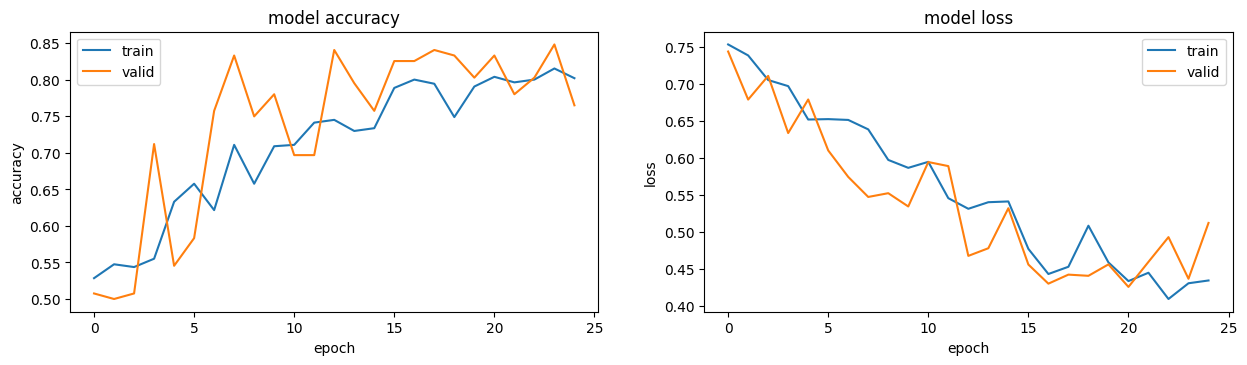

In [ ]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(hist_df['accuracy'])
plt.plot(hist_df['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

In [ ]:
test_generator.reset()
prediction = model.predict(test_generator)
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(prediction))

165/165 [==============================] - 8s 35ms/step


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.6727272727272727
0.6746031746031745
              precision    recall  f1-score   support

           0       0.73      0.57      0.64        84
           1       0.64      0.78      0.70        81

    accuracy                           0.67       165
   macro avg       0.68      0.67      0.67       165
weighted avg       0.68      0.67      0.67       165



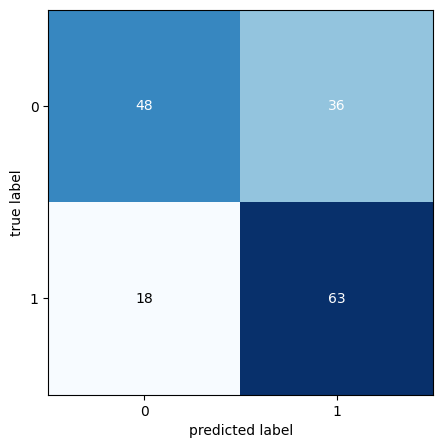

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
predicted_class_indices = np.round(predicted_class_indices)
y_test = labels
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))
plt.show()

In [ ]:
model_save_path = '/content/drive/My Drive/your_folder/"ori_one_fold_new_transfer_09_20.h5"'
model.save(model_save_path)

616/616 [==============================] - 63s 102ms/step
(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.599025974025974
0.6094605572729287
              precision    recall  f1-score   support

           0       0.89      0.25      0.39       317
           1       0.55      0.97      0.70       299

    accuracy                           0.60       616
   macro avg       0.72      0.61      0.55       616
weighted avg       0.72      0.60      0.54       616



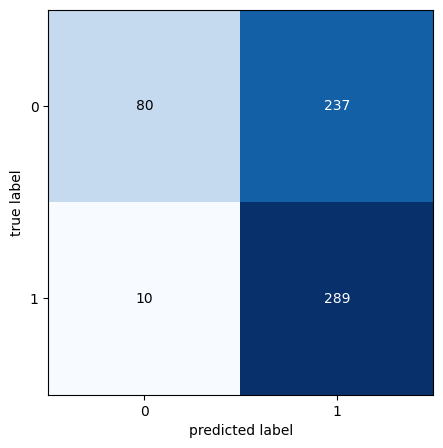

In [ ]:
train_generator_test.reset()
valid_generator_test.reset()
test_generator_test.reset()
combined_prediction = []
combined_prediction.extend(model.predict(test_generator_test))
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator_test)):
    batch_images, batch_labels = test_generator_test.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(combined_prediction))
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels.T
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))

# New Transfer Learning 0.9 Iterations = 10

In [ ]:
valid_generator.reset()

In [ ]:
img_size = 224
dropout_prob = 0.9
weights = "DenseNet_224_up_uncrop.h5"
iterations = 10

In [ ]:
class CustomDropout(Layer):
    def __init__(self, dropout_prob,weights = None):
        super(CustomDropout, self).__init__()
        self.dropout_prob = dropout_prob
        self.masks = None

    def call(self, train_inputs, training=False):
        if training:
          if self.masks is not None:
            modified_object = train_inputs * self.masks
            modified_tensor = tf.convert_to_tensor(modified_object)
            return modified_tensor
        return train_inputs

In [ ]:
base_model = DenseNet121(weights=None, include_top=False,
                                 input_shape = (img_size,img_size,3))
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout = CustomDropout(dropout_prob)
x = dropout(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))
model.load_weights(weights)
num_layers_to_freeze = 300  # You can adjust this fraction as needed
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout_one = CustomDropout(dropout_prob)
x = dropout_one(x)
before_predictions = layers.Dense(128, activation='relu')
x = before_predictions(x)
dropout_two = CustomDropout(dropout_prob)
x = dropout_two(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))

In [ ]:
import tensorflow.keras.backend as K
print("Compiling the model...")
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[0] ** (1 - y_true)) * (weights[1] ** y_true) * K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
opt = Adam(lr=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy","AUC","Precision","Recall"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Compiling the model...


In [ ]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_6 (ZeroPadd  (None, 230, 230, 3)          0         ['input_4[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_6[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
num_batches_to_consider = len(valid_generator)
num_batches_to_consider

3

In [ ]:
def custom_random_binomial(random_values,shape, prob, object_to_modify):
    random_values = np.broadcast_to(random_values, shape)
    mask = (random_values < (1-prob)).astype(np.float32)
    modified_object = object_to_modify * mask
    modified_tensor = tf.convert_to_tensor(modified_object)
    return modified_tensor,mask

In [ ]:
def custom_valid_generator(generator, subset_indices):
    max_index = max(subset_indices, default=-1)
    for i, (x, y) in enumerate(generator):
        if i <= max_index:
            yield (x, y)
        else:
            return

In [ ]:
# train the head of the network
def calculate_metric(test_y, test_preds, metric):
  if metric == "auc":
    try:
      # auc = roc_auc_score(test_y.numpy(), np.argmax(test_preds.numpy(), axis=1))
      auc = roc_auc_score(test_y.numpy(),test_preds.numpy())
      return auc
    except:
      return 0.0
    else:
      raise ValueError("Unsupported metric: " + metric)
print("training the head...")
hist_df_list = []
epochs = 25
dropout = [dropout_one,dropout_two]
for i in range(epochs):
  print(f"Epochs {i+1}")
  best_dropout_score = float("-inf")
  weight_best = None
  if dropout_prob < 0 or dropout_prob > 1:
    raise ValueError('Dropout probability has to be between 0 and 1, but got ' + str(dropout_prob))
  for iteration in range(iterations):
    np.random.seed((i+1) * iterations)
    # dropout_layer = tf.keras.layers.Dropout(dropout_prob)
    vbatch_images_array = []
    vbatch_labels_array = []
    for v_step in range(num_batches_to_consider):
      vbatch_images, vbatch_labels = valid_generator[v_step]
      vbatch_images_array.append(vbatch_images)
      vbatch_labels_array.append(vbatch_labels)
    vbatch_images = np.concatenate(vbatch_images_array)
    vbatch_labels = np.concatenate(vbatch_labels_array)

    output = globa(base_model(vbatch_images))
    shape = output.shape
    random_values_one = np.random.random(shape)[0]
    non_mask_one,mask_numpy_one = custom_random_binomial(random_values_one,shape,dropout_prob,output)
    output = before_predictions(non_mask_one)
    shape = output.shape
    random_values_two = np.random.random(shape)[0]
    non_mask_two,mask_numpy_two = custom_random_binomial(random_values_two,shape,dropout_prob,output)
    dropout_score = calculate_metric(vbatch_labels,predictions(non_mask_two),"auc")
    if dropout_score > best_dropout_score:
      best_dropout_score = dropout_score
      weight_best_one = random_values_one
      weight_best_two = random_values_two
  if weight_best is not None:
    dropout[0].masks = weight_best_one
    dropout[1].masks = weight_best_two
  model.compile(loss='binary_crossentropy', optimizer="RMSprop", metrics=["accuracy","AUC","Precision","Recall"])
  history = model.fit(
          train_generator,
          epochs = 1,
          validation_data=valid_generator,
          callbacks=[cb_checkpointer,learning_rate_reduction,cb_early_stopper],
   )
  epoch_hist_df = pd.DataFrame(history.history)
  hist_df_list.append(epoch_hist_df)

# convert the history.history dict to a pandas DataFrame:
hist_df = pd.concat(hist_df_list, ignore_index=True)

training the head...
Epochs 1
9/9 [==============================] - 27s 1s/step - loss: 0.9068 - accuracy: 0.5057 - auc: 0.5203 - precision: 0.4952 - recall: 0.4031 - val_loss: 0.6938 - val_accuracy: 0.5076 - val_auc: 0.6187 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epochs 2
9/9 [==============================] - 28s 1s/step - loss: 0.7416 - accuracy: 0.5475 - auc: 0.5669 - precision: 0.5450 - recall: 0.4690 - val_loss: 0.7605 - val_accuracy: 0.4924 - val_auc: 0.8148 - val_precision: 0.4924 - val_recall: 1.0000 - lr: 0.0010
Epochs 3
9/9 [==============================] - 28s 1s/step - loss: 0.7383 - accuracy: 0.5570 - auc: 0.5677 - precision: 0.5448 - recall: 0.5891 - val_loss: 0.6679 - val_accuracy: 0.5379 - val_auc: 0.8091 - val_precision: 0.5164 - val_recall: 0.9692 - lr: 0.0010
Epochs 4
9/9 [==============================] - 27s 1s/step - loss: 0.7236 - accuracy: 0.5608 - auc: 0.6011 - precision: 0.5628 - recall: 0.4690 - val_loss: 0.7114 - val_accuracy: 0.

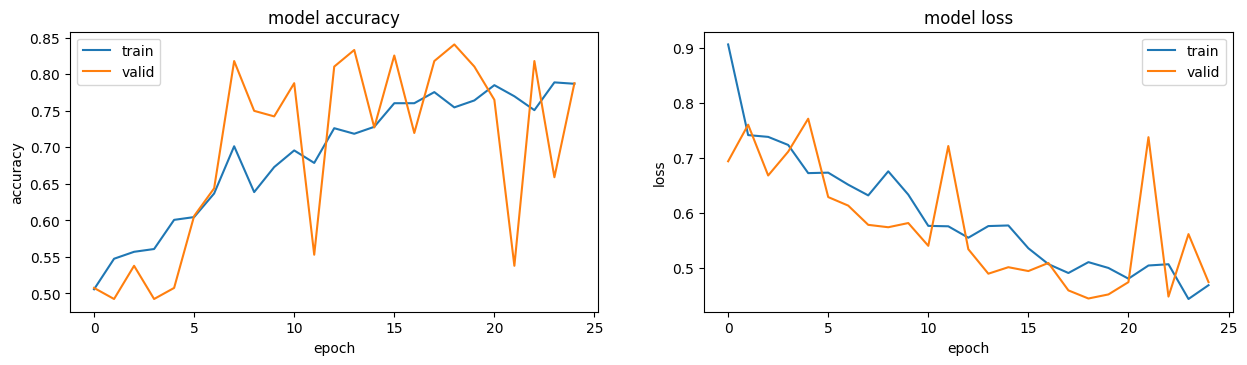

In [ ]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(hist_df['accuracy'])
plt.plot(hist_df['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

In [ ]:
test_generator.reset()
prediction = model.predict(test_generator)
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(prediction))

165/165 [==============================] - 8s 36ms/step


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.6848484848484848
0.6867283950617283
              precision    recall  f1-score   support

           0       0.74      0.58      0.65        84
           1       0.65      0.79      0.71        81

    accuracy                           0.68       165
   macro avg       0.69      0.69      0.68       165
weighted avg       0.70      0.68      0.68       165



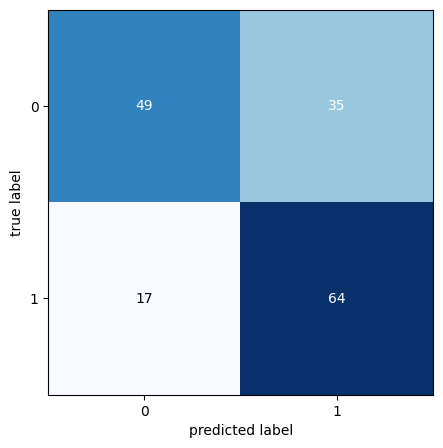

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
predicted_class_indices = np.round(predicted_class_indices)
y_test = labels
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))
plt.show()

In [ ]:
model_save_path = '/content/drive/My Drive/your_folder/"ori_one_fold_new_transfer_09_20.h5"'
model.save(model_save_path)

616/616 [==============================] - 51s 82ms/step
(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.6412337662337663
0.6499952523131786
              precision    recall  f1-score   support

           0       0.88      0.35      0.50       317
           1       0.58      0.95      0.72       299

    accuracy                           0.64       616
   macro avg       0.73      0.65      0.61       616
weighted avg       0.73      0.64      0.61       616



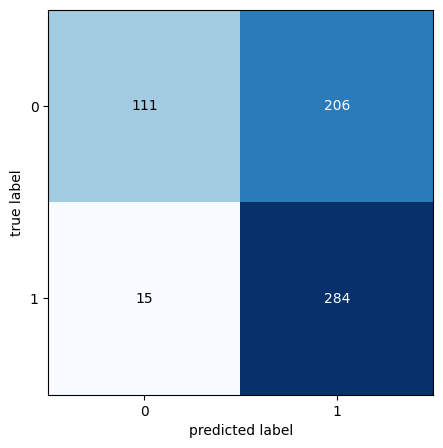

In [ ]:
train_generator_test.reset()
valid_generator_test.reset()
test_generator_test.reset()
combined_prediction = []
combined_prediction.extend(model.predict(test_generator_test))
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator_test)):
    batch_images, batch_labels = test_generator_test.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(combined_prediction))
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels.T
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))

# New Transfer Learning 0.3 Iterations = 20

In [ ]:
valid_generator.reset()

In [ ]:
img_size = 224
dropout_prob = 0.3
weights = "DenseNet_224_up_uncrop.h5"
iterations = 20

In [ ]:
class CustomDropout(Layer):
    def __init__(self, dropout_prob,weights = None):
        super(CustomDropout, self).__init__()
        self.dropout_prob = dropout_prob
        self.masks = None

    def call(self, train_inputs, training=False):
        if training:
          if self.masks is not None:
            modified_object = train_inputs * self.masks
            modified_tensor = tf.convert_to_tensor(modified_object)
            return modified_tensor
        return train_inputs

In [ ]:
base_model = DenseNet121(weights=None, include_top=False,
                                 input_shape = (img_size,img_size,3))
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout = CustomDropout(dropout_prob)
x = dropout(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))
model.load_weights(weights)
num_layers_to_freeze = 300  # You can adjust this fraction as needed
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout_one = CustomDropout(dropout_prob)
x = dropout_one(x)
before_predictions = layers.Dense(128, activation='relu')
x = before_predictions(x)
dropout_two = CustomDropout(dropout_prob)
x = dropout_two(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))

In [ ]:
import tensorflow.keras.backend as K
print("Compiling the model...")
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[0] ** (1 - y_true)) * (weights[1] ** y_true) * K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
opt = Adam(lr=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy","AUC","Precision","Recall"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Compiling the model...


In [ ]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_8 (ZeroPadd  (None, 230, 230, 3)          0         ['input_5[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_8[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
num_batches_to_consider = len(valid_generator)
num_batches_to_consider

3

In [ ]:
def custom_random_binomial(random_values,shape, prob, object_to_modify):
    random_values = np.broadcast_to(random_values, shape)
    mask = (random_values < (1-prob)).astype(np.float32)
    modified_object = object_to_modify * mask
    modified_tensor = tf.convert_to_tensor(modified_object)
    return modified_tensor,mask

In [ ]:
def custom_valid_generator(generator, subset_indices):
    max_index = max(subset_indices, default=-1)
    for i, (x, y) in enumerate(generator):
        if i <= max_index:
            yield (x, y)
        else:
            return

In [ ]:
# train the head of the network
def calculate_metric(test_y, test_preds, metric):
  if metric == "auc":
    try:
      # auc = roc_auc_score(test_y.numpy(), np.argmax(test_preds.numpy(), axis=1))
      auc = roc_auc_score(test_y.numpy(),test_preds.numpy())
      return auc
    except:
      return 0.0
    else:
      raise ValueError("Unsupported metric: " + metric)
print("training the head...")
hist_df_list = []
epochs = 25
dropout = [dropout_one,dropout_two]
for i in range(epochs):
  print(f"Epochs {i+1}")
  best_dropout_score = float("-inf")
  weight_best = None
  if dropout_prob < 0 or dropout_prob > 1:
    raise ValueError('Dropout probability has to be between 0 and 1, but got ' + str(dropout_prob))
  for iteration in range(iterations):
    np.random.seed((i+1) * iterations)
    # dropout_layer = tf.keras.layers.Dropout(dropout_prob)
    vbatch_images_array = []
    vbatch_labels_array = []
    for v_step in range(num_batches_to_consider):
      vbatch_images, vbatch_labels = valid_generator[v_step]
      vbatch_images_array.append(vbatch_images)
      vbatch_labels_array.append(vbatch_labels)
    vbatch_images = np.concatenate(vbatch_images_array)
    vbatch_labels = np.concatenate(vbatch_labels_array)

    output = globa(base_model(vbatch_images))
    shape = output.shape
    random_values_one = np.random.random(shape)[0]
    non_mask_one,mask_numpy_one = custom_random_binomial(random_values_one,shape,dropout_prob,output)
    output = before_predictions(non_mask_one)
    shape = output.shape
    random_values_two = np.random.random(shape)[0]
    non_mask_two,mask_numpy_two = custom_random_binomial(random_values_two,shape,dropout_prob,output)
    dropout_score = calculate_metric(vbatch_labels,predictions(non_mask_two),"auc")
    if dropout_score > best_dropout_score:
      best_dropout_score = dropout_score
      weight_best_one = random_values_one
      weight_best_two = random_values_two
  if weight_best is not None:
    dropout[0].masks = weight_best_one
    dropout[1].masks = weight_best_two
  model.compile(loss='binary_crossentropy', optimizer="RMSprop", metrics=["accuracy","AUC","Precision","Recall"])
  history = model.fit(
          train_generator,
          epochs = 1,
          validation_data=valid_generator,
          callbacks=[cb_checkpointer,learning_rate_reduction,cb_early_stopper],
   )
  epoch_hist_df = pd.DataFrame(history.history)
  hist_df_list.append(epoch_hist_df)

# convert the history.history dict to a pandas DataFrame:
hist_df = pd.concat(hist_df_list, ignore_index=True)

training the head...
Epochs 1
9/9 [==============================] - 28s 2s/step - loss: 0.8405 - accuracy: 0.5266 - auc: 0.5789 - precision: 0.5217 - recall: 0.4186 - val_loss: 0.6776 - val_accuracy: 0.5227 - val_auc: 0.7534 - val_precision: 1.0000 - val_recall: 0.0308 - lr: 0.0010
Epochs 2
9/9 [==============================] - 26s 1s/step - loss: 0.7870 - accuracy: 0.5152 - auc: 0.5528 - precision: 0.5069 - recall: 0.4264 - val_loss: 0.6813 - val_accuracy: 0.5000 - val_auc: 0.8250 - val_precision: 0.4962 - val_recall: 1.0000 - lr: 0.0010
Epochs 3
9/9 [==============================] - 30s 2s/step - loss: 0.7500 - accuracy: 0.5703 - auc: 0.5695 - precision: 0.5571 - recall: 0.6047 - val_loss: 0.6463 - val_accuracy: 0.7197 - val_auc: 0.7930 - val_precision: 0.9375 - val_recall: 0.4615 - lr: 0.0010
Epochs 4
9/9 [==============================] - 43s 2s/step - loss: 0.6865 - accuracy: 0.6027 - auc: 0.6404 - precision: 0.5932 - recall: 0.6047 - val_loss: 0.6305 - val_accuracy: 0.6591 - v

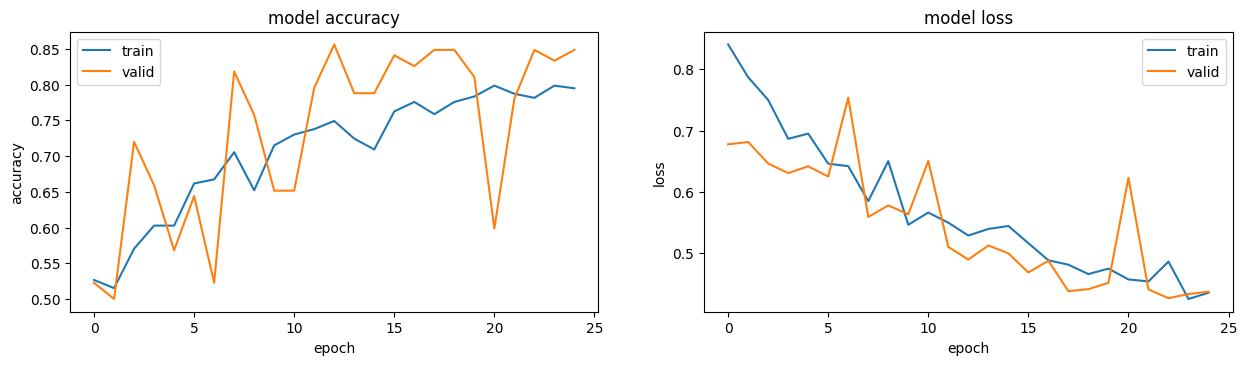

In [ ]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(hist_df['accuracy'])
plt.plot(hist_df['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

In [ ]:
test_generator.reset()
prediction = model.predict(test_generator)
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(prediction))

165/165 [==============================] - 6s 23ms/step


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.7393939393939394
0.7387566137566137
              precision    recall  f1-score   support

           0       0.73      0.77      0.75        84
           1       0.75      0.70      0.73        81

    accuracy                           0.74       165
   macro avg       0.74      0.74      0.74       165
weighted avg       0.74      0.74      0.74       165



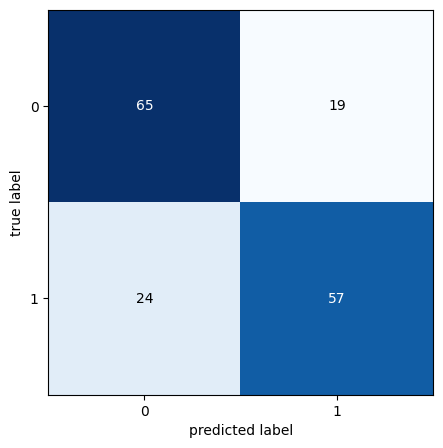

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
predicted_class_indices = np.round(predicted_class_indices)
y_test = labels
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))
plt.show()

In [ ]:
model_save_path = '/content/drive/My Drive/your_folder/"ori_one_fold_new_transfer_09_20.h5"'
model.save(model_save_path)

616/616 [==============================] - 62s 101ms/step
(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.6396103896103896
0.6477532890919258
              precision    recall  f1-score   support

           0       0.84      0.37      0.51       317
           1       0.58      0.93      0.71       299

    accuracy                           0.64       616
   macro avg       0.71      0.65      0.61       616
weighted avg       0.72      0.64      0.61       616



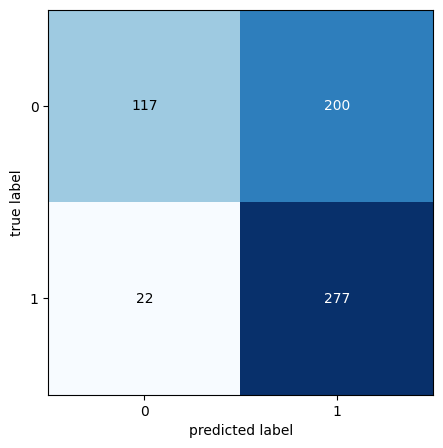

In [ ]:
train_generator_test.reset()
valid_generator_test.reset()
test_generator_test.reset()
combined_prediction = []
combined_prediction.extend(model.predict(test_generator_test))
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator_test)):
    batch_images, batch_labels = test_generator_test.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(combined_prediction))
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels.T
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))

# New Transfer Learning 0.6 Iterations = 20

In [ ]:
valid_generator.reset()

In [ ]:
img_size = 224
dropout_prob = 0.6
weights = "DenseNet_224_up_uncrop.h5"
iterations = 20

In [ ]:
class CustomDropout(Layer):
    def __init__(self, dropout_prob,weights = None):
        super(CustomDropout, self).__init__()
        self.dropout_prob = dropout_prob
        self.masks = None

    def call(self, train_inputs, training=False):
        if training:
          if self.masks is not None:
            modified_object = train_inputs * self.masks
            modified_tensor = tf.convert_to_tensor(modified_object)
            return modified_tensor
        return train_inputs

In [ ]:
base_model = DenseNet121(weights=None, include_top=False,
                                 input_shape = (img_size,img_size,3))
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout = CustomDropout(dropout_prob)
x = dropout(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))
model.load_weights(weights)
num_layers_to_freeze = 300  # You can adjust this fraction as needed
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout_one = CustomDropout(dropout_prob)
x = dropout_one(x)
before_predictions = layers.Dense(128, activation='relu')
x = before_predictions(x)
dropout_two = CustomDropout(dropout_prob)
x = dropout_two(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))

In [ ]:
import tensorflow.keras.backend as K
print("Compiling the model...")
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[0] ** (1 - y_true)) * (weights[1] ** y_true) * K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
opt = Adam(lr=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy","AUC","Precision","Recall"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Compiling the model...


In [ ]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_10 (ZeroPad  (None, 230, 230, 3)          0         ['input_6[0][0]']             
 ding2D)                                                                                          
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_10[0][0]']   
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']   

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
num_batches_to_consider = len(valid_generator)
num_batches_to_consider

3

In [ ]:
def custom_random_binomial(random_values,shape, prob, object_to_modify):
    random_values = np.broadcast_to(random_values, shape)
    mask = (random_values < (1-prob)).astype(np.float32)
    modified_object = object_to_modify * mask
    modified_tensor = tf.convert_to_tensor(modified_object)
    return modified_tensor,mask

In [ ]:
def custom_valid_generator(generator, subset_indices):
    max_index = max(subset_indices, default=-1)
    for i, (x, y) in enumerate(generator):
        if i <= max_index:
            yield (x, y)
        else:
            return

In [ ]:
# train the head of the network
def calculate_metric(test_y, test_preds, metric):
  if metric == "auc":
    try:
      # auc = roc_auc_score(test_y.numpy(), np.argmax(test_preds.numpy(), axis=1))
      auc = roc_auc_score(test_y.numpy(),test_preds.numpy())
      return auc
    except:
      return 0.0
    else:
      raise ValueError("Unsupported metric: " + metric)
print("training the head...")
hist_df_list = []
epochs = 25
dropout = [dropout_one,dropout_two]
for i in range(epochs):
  print(f"Epochs {i+1}")
  best_dropout_score = float("-inf")
  weight_best = None
  if dropout_prob < 0 or dropout_prob > 1:
    raise ValueError('Dropout probability has to be between 0 and 1, but got ' + str(dropout_prob))
  for iteration in range(iterations):
    np.random.seed((i+1) * iterations)
    # dropout_layer = tf.keras.layers.Dropout(dropout_prob)
    vbatch_images_array = []
    vbatch_labels_array = []
    for v_step in range(num_batches_to_consider):
      vbatch_images, vbatch_labels = valid_generator[v_step]
      vbatch_images_array.append(vbatch_images)
      vbatch_labels_array.append(vbatch_labels)
    vbatch_images = np.concatenate(vbatch_images_array)
    vbatch_labels = np.concatenate(vbatch_labels_array)

    output = globa(base_model(vbatch_images))
    shape = output.shape
    random_values_one = np.random.random(shape)[0]
    non_mask_one,mask_numpy_one = custom_random_binomial(random_values_one,shape,dropout_prob,output)
    output = before_predictions(non_mask_one)
    shape = output.shape
    random_values_two = np.random.random(shape)[0]
    non_mask_two,mask_numpy_two = custom_random_binomial(random_values_two,shape,dropout_prob,output)
    dropout_score = calculate_metric(vbatch_labels,predictions(non_mask_two),"auc")
    if dropout_score > best_dropout_score:
      best_dropout_score = dropout_score
      weight_best_one = random_values_one
      weight_best_two = random_values_two
  if weight_best is not None:
    dropout[0].masks = weight_best_one
    dropout[1].masks = weight_best_two
  model.compile(loss='binary_crossentropy', optimizer="RMSprop", metrics=["accuracy","AUC","Precision","Recall"])
  history = model.fit(
          train_generator,
          epochs = 1,
          validation_data=valid_generator,
          callbacks=[cb_checkpointer,learning_rate_reduction,cb_early_stopper],
   )
  epoch_hist_df = pd.DataFrame(history.history)
  hist_df_list.append(epoch_hist_df)

# convert the history.history dict to a pandas DataFrame:
hist_df = pd.concat(hist_df_list, ignore_index=True)

training the head...
Epochs 1
9/9 [==============================] - 30s 2s/step - loss: 0.8886 - accuracy: 0.5019 - auc: 0.5130 - precision: 0.4914 - recall: 0.4419 - val_loss: 0.6748 - val_accuracy: 0.6364 - val_auc: 0.7007 - val_precision: 0.7073 - val_recall: 0.4462 - lr: 0.0010
Epochs 2
9/9 [==============================] - 31s 2s/step - loss: 0.7860 - accuracy: 0.5760 - auc: 0.5798 - precision: 0.5751 - recall: 0.5194 - val_loss: 0.6663 - val_accuracy: 0.5455 - val_auc: 0.7685 - val_precision: 0.8571 - val_recall: 0.0923 - lr: 0.0010
Epochs 3
9/9 [==============================] - 31s 2s/step - loss: 0.7259 - accuracy: 0.6046 - auc: 0.5826 - precision: 0.6116 - recall: 0.5310 - val_loss: 0.6665 - val_accuracy: 0.5076 - val_auc: 0.7832 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epochs 4
9/9 [==============================] - 31s 2s/step - loss: 0.7171 - accuracy: 0.5894 - auc: 0.5991 - precision: 0.5875 - recall: 0.5465 - val_loss: 0.6242 - val_accuracy: 0.

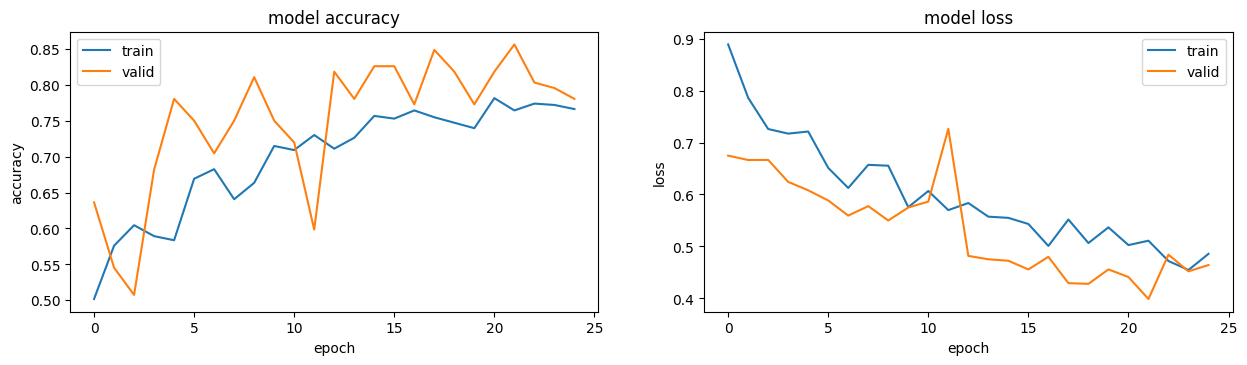

In [ ]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(hist_df['accuracy'])
plt.plot(hist_df['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

In [ ]:
test_generator.reset()
prediction = model.predict(test_generator)
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(prediction))

165/165 [==============================] - 8s 36ms/step


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.7393939393939394
0.7391975308641975
              precision    recall  f1-score   support

           0       0.74      0.75      0.75        84
           1       0.74      0.73      0.73        81

    accuracy                           0.74       165
   macro avg       0.74      0.74      0.74       165
weighted avg       0.74      0.74      0.74       165



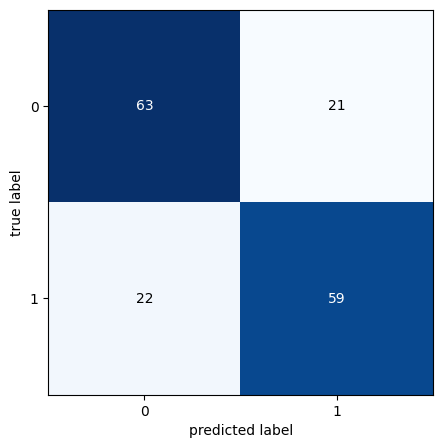

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
predicted_class_indices = np.round(predicted_class_indices)
y_test = labels
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))
plt.show()

In [ ]:
model_save_path = '/content/drive/My Drive/your_folder/"ori_one_fold_new_transfer_09_20.h5"'
model.save(model_save_path)

616/616 [==============================] - 53s 86ms/step
(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.637987012987013
0.647315446862834
              precision    recall  f1-score   support

           0       0.91      0.33      0.48       317
           1       0.58      0.97      0.72       299

    accuracy                           0.64       616
   macro avg       0.74      0.65      0.60       616
weighted avg       0.75      0.64      0.60       616



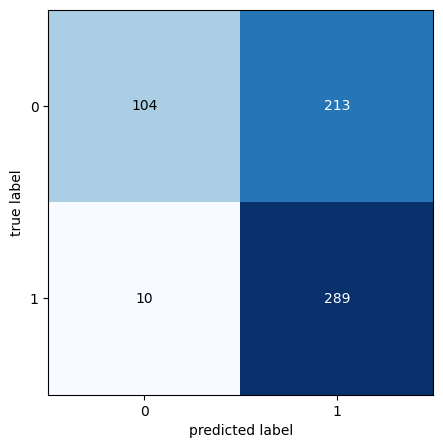

In [ ]:
train_generator_test.reset()
valid_generator_test.reset()
test_generator_test.reset()
combined_prediction = []
combined_prediction.extend(model.predict(test_generator_test))
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator_test)):
    batch_images, batch_labels = test_generator_test.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(combined_prediction))
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels.T
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))

# New Transfer Learning 0.9 Iterations = 20

In [ ]:
valid_generator.reset()

In [ ]:
img_size = 224
dropout_prob = 0.9
weights = "DenseNet_224_up_uncrop.h5"
iterations = 20

In [ ]:
class CustomDropout(Layer):
    def __init__(self, dropout_prob,weights = None):
        super(CustomDropout, self).__init__()
        self.dropout_prob = dropout_prob
        self.masks = None

    def call(self, train_inputs, training=False):
        if training:
          if self.masks is not None:
            modified_object = train_inputs * self.masks
            modified_tensor = tf.convert_to_tensor(modified_object)
            return modified_tensor
        return train_inputs

In [ ]:
base_model = DenseNet121(weights=None, include_top=False,
                                 input_shape = (img_size,img_size,3))
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout = CustomDropout(dropout_prob)
x = dropout(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))
model.load_weights(weights)
num_layers_to_freeze = 300  # You can adjust this fraction as needed
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout_one = CustomDropout(dropout_prob)
x = dropout_one(x)
before_predictions = layers.Dense(128, activation='relu')
x = before_predictions(x)
dropout_two = CustomDropout(dropout_prob)
x = dropout_two(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))

In [ ]:
import tensorflow.keras.backend as K
print("Compiling the model...")
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[0] ** (1 - y_true)) * (weights[1] ** y_true) * K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
opt = Adam(lr=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy","AUC","Precision","Recall"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Compiling the model...


In [ ]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_12 (ZeroPad  (None, 230, 230, 3)          0         ['input_7[0][0]']             
 ding2D)                                                                                          
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_12[0][0]']   
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']   

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
num_batches_to_consider = len(valid_generator)
num_batches_to_consider

3

In [ ]:
def custom_random_binomial(random_values,shape, prob, object_to_modify):
    random_values = np.broadcast_to(random_values, shape)
    mask = (random_values < (1-prob)).astype(np.float32)
    modified_object = object_to_modify * mask
    modified_tensor = tf.convert_to_tensor(modified_object)
    return modified_tensor,mask

In [ ]:
def custom_valid_generator(generator, subset_indices):
    max_index = max(subset_indices, default=-1)
    for i, (x, y) in enumerate(generator):
        if i <= max_index:
            yield (x, y)
        else:
            return

In [ ]:
# train the head of the network
def calculate_metric(test_y, test_preds, metric):
  if metric == "auc":
    try:
      # auc = roc_auc_score(test_y.numpy(), np.argmax(test_preds.numpy(), axis=1))
      auc = roc_auc_score(test_y.numpy(),test_preds.numpy())
      return auc
    except:
      return 0.0
    else:
      raise ValueError("Unsupported metric: " + metric)
print("training the head...")
hist_df_list = []
epochs = 25
dropout = [dropout_one,dropout_two]
for i in range(epochs):
  print(f"Epochs {i+1}")
  best_dropout_score = float("-inf")
  weight_best = None
  if dropout_prob < 0 or dropout_prob > 1:
    raise ValueError('Dropout probability has to be between 0 and 1, but got ' + str(dropout_prob))
  for iteration in range(iterations):
    np.random.seed((i+1) * iterations)
    # dropout_layer = tf.keras.layers.Dropout(dropout_prob)
    vbatch_images_array = []
    vbatch_labels_array = []
    for v_step in range(num_batches_to_consider):
      vbatch_images, vbatch_labels = valid_generator[v_step]
      vbatch_images_array.append(vbatch_images)
      vbatch_labels_array.append(vbatch_labels)
    vbatch_images = np.concatenate(vbatch_images_array)
    vbatch_labels = np.concatenate(vbatch_labels_array)

    output = globa(base_model(vbatch_images))
    shape = output.shape
    random_values_one = np.random.random(shape)[0]
    non_mask_one,mask_numpy_one = custom_random_binomial(random_values_one,shape,dropout_prob,output)
    output = before_predictions(non_mask_one)
    shape = output.shape
    random_values_two = np.random.random(shape)[0]
    non_mask_two,mask_numpy_two = custom_random_binomial(random_values_two,shape,dropout_prob,output)
    dropout_score = calculate_metric(vbatch_labels,predictions(non_mask_two),"auc")
    if dropout_score > best_dropout_score:
      best_dropout_score = dropout_score
      weight_best_one = random_values_one
      weight_best_two = random_values_two
  if weight_best is not None:
    dropout[0].masks = weight_best_one
    dropout[1].masks = weight_best_two
  model.compile(loss='binary_crossentropy', optimizer="RMSprop", metrics=["accuracy","AUC","Precision","Recall"])
  history = model.fit(
          train_generator,
          epochs = 1,
          validation_data=valid_generator,
          callbacks=[cb_checkpointer,learning_rate_reduction,cb_early_stopper],
   )
  epoch_hist_df = pd.DataFrame(history.history)
  hist_df_list.append(epoch_hist_df)

# convert the history.history dict to a pandas DataFrame:
hist_df = pd.concat(hist_df_list, ignore_index=True)

training the head...
Epochs 1
9/9 [==============================] - 29s 2s/step - loss: 0.8651 - accuracy: 0.5114 - auc: 0.5080 - precision: 0.5027 - recall: 0.3643 - val_loss: 0.7303 - val_accuracy: 0.4924 - val_auc: 0.5576 - val_precision: 0.4924 - val_recall: 1.0000 - lr: 0.0010
Epochs 2
9/9 [==============================] - 27s 1s/step - loss: 0.7563 - accuracy: 0.5646 - auc: 0.5933 - precision: 0.5516 - recall: 0.6008 - val_loss: 0.7631 - val_accuracy: 0.5076 - val_auc: 0.6718 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epochs 3
9/9 [==============================] - 30s 2s/step - loss: 0.7305 - accuracy: 0.5513 - auc: 0.5703 - precision: 0.5458 - recall: 0.5078 - val_loss: 0.6605 - val_accuracy: 0.6970 - val_auc: 0.7150 - val_precision: 0.8049 - val_recall: 0.5077 - lr: 0.0010
Epochs 4
9/9 [==============================] - 30s 2s/step - loss: 0.6779 - accuracy: 0.6103 - auc: 0.6529 - precision: 0.6244 - recall: 0.5155 - val_loss: 0.6541 - val_accuracy: 0.

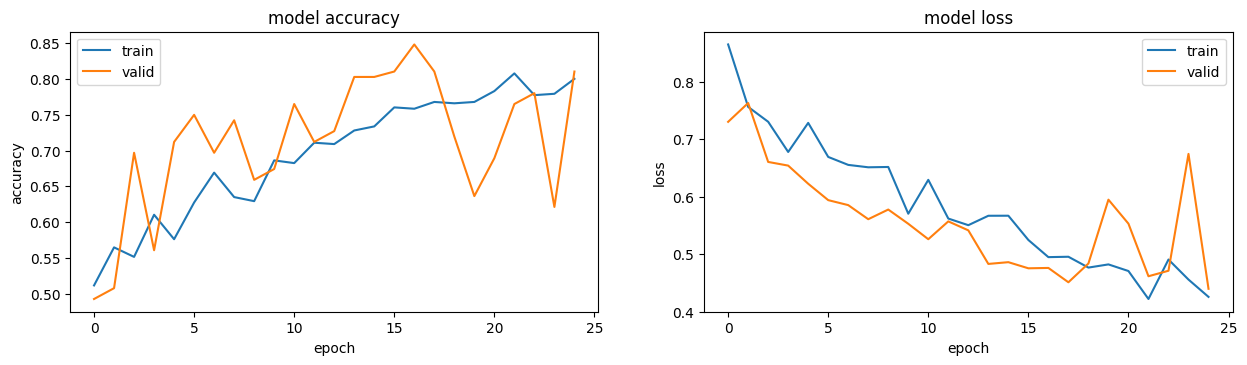

In [ ]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(hist_df['accuracy'])
plt.plot(hist_df['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

In [ ]:
test_generator.reset()
prediction = model.predict(test_generator)
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(prediction))

165/165 [==============================] - 7s 33ms/step


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.7818181818181819
0.7806437389770724
              precision    recall  f1-score   support

           0       0.76      0.85      0.80        84
           1       0.82      0.72      0.76        81

    accuracy                           0.78       165
   macro avg       0.79      0.78      0.78       165
weighted avg       0.79      0.78      0.78       165



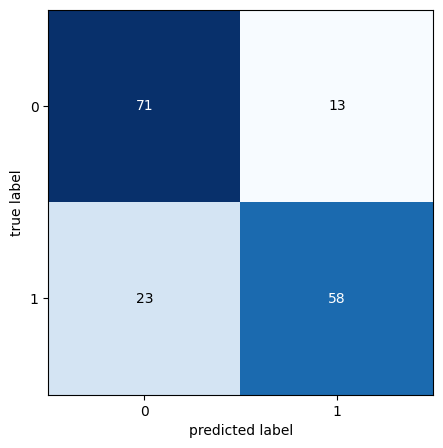

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
predicted_class_indices = np.round(predicted_class_indices)
y_test = labels
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))
plt.show()

In [ ]:
model_save_path = '/content/drive/My Drive/your_folder/"ori_one_fold_new_transfer_09_20.h5"'
model.save(model_save_path)

616/616 [==============================] - 76s 124ms/step
(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.724025974025974
0.7295823090638617
              precision    recall  f1-score   support

           0       0.88      0.54      0.67       317
           1       0.65      0.92      0.76       299

    accuracy                           0.72       616
   macro avg       0.77      0.73      0.72       616
weighted avg       0.77      0.72      0.71       616



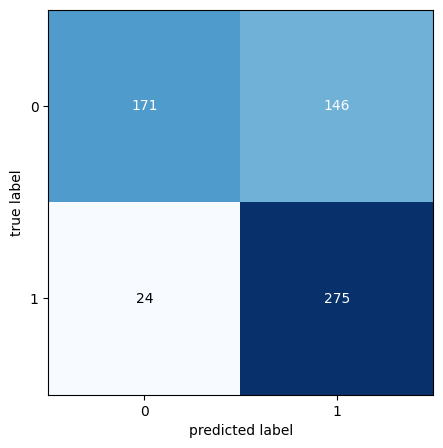

In [ ]:
train_generator_test.reset()
valid_generator_test.reset()
test_generator_test.reset()
combined_prediction = []
combined_prediction.extend(model.predict(test_generator_test))
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator_test)):
    batch_images, batch_labels = test_generator_test.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(combined_prediction))
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels.T
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))